<a href="https://colab.research.google.com/github/ngcheeyuan/HDB-Resale-Flat/blob/main/HDB_price_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.request import Request, urlopen
import datetime
import json
import time
from google.colab import files

%matplotlib inline

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.model_selection import  train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

In [ ]:
#url = "https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3"
#req = Request(url, headers = {'User-Agent': 'yuan'})
#Response = urlopen(req).read()

In [ ]:
#output = json.loads(Response.decode('utf-8'))
#pd.DataFrame(output['result']['records'])

In [ ]:
DATA_PATH = "/content/drive/MyDrive/HDB Resale/"
df_2017 = pd.read_csv(DATA_PATH + 'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df_2015 = pd.read_csv(DATA_PATH + 'resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df_2012 = pd.read_csv(DATA_PATH + 'resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df_2000 = pd.read_csv(DATA_PATH + 'resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')

In [ ]:
df = pd.concat([df_2017,df_2015,df_2012,df_2000,],axis = 0)
df['year_month'] = pd.to_datetime(df['month'])

In [ ]:
flat_models = df['flat_model'].value_counts().head(9).reset_index()['index'].tolist()

In [ ]:
df.isna().sum()

month                             0
town                              0
flat_type                         0
block                             0
street_name                       0
storey_range                      0
floor_area_sqm                    0
flat_model                        0
lease_commence_date               0
remaining_lease              421308
resale_price                      0
year_month                        0
trans_month                       0
trans_year                        0
estimated_remaining_lease         0
dollar_per_sm                     0
age_bins                          0
storey_bins                       0
dtype: int64

In [ ]:
print(f'percentage null : {round(df.remaining_lease.isna().sum()/len(df) * 100,2)}%')

percentage null : 73.52%


More than 73% of the data in "remaining_lease" field are Null.

In [ ]:
df['trans_month'] = df['year_month'].dt.month
df['trans_year'] = df['year_month'].dt.year
df.sort_values(by = 'year_month', inplace = True)
df['estimated_remaining_lease'] = df.lease_commence_date + 99 - df.trans_year
df['dollar_per_sm'] = df['resale_price']/df['floor_area_sqm']

In [ ]:
df.loc[df['estimated_remaining_lease']>99]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year_month,trans_month,trans_year,estimated_remaining_lease,dollar_per_sm
157846,2004-09,BUKIT MERAH,4 ROOM,112A,DEPOT RD,22 TO 24,100.0,Model A,2006,NaN,348000.0,2004-09-01,9,2004,101,3480.000000
162626,2004-11,BUKIT MERAH,4 ROOM,109B,DEPOT RD,25 TO 27,100.0,Model A,2006,NaN,358000.0,2004-11-01,11,2004,101,3580.000000
167746,2005-01,BUKIT MERAH,5 ROOM,111A,DEPOT RD,22 TO 24,115.0,Improved,2006,NaN,388000.0,2005-01-01,1,2005,100,3373.913043
167747,2005-01,BUKIT MERAH,5 ROOM,112B,DEPOT RD,22 TO 24,116.0,Improved,2006,NaN,378000.0,2005-01-01,1,2005,100,3258.620690
172852,2005-03,BUKIT MERAH,5 ROOM,109A,DEPOT RD,07 TO 09,116.0,Improved,2006,NaN,416300.0,2005-03-01,3,2005,100,3588.793103
175738,2005-04,BUKIT MERAH,5 ROOM,111B,DEPOT RD,22 TO 24,116.0,Improved,2006,NaN,401999.0,2005-04-01,4,2005,100,3465.508621
178191,2005-05,BUKIT MERAH,5 ROOM,111B,DEPOT RD,22 TO 24,116.0,Improved,2006,NaN,383999.0,2005-05-01,5,2005,100,3310.336207
180141,2005-06,ANG MO KIO,5 ROOM,316A,ANG MO KIO ST 31,28 TO 30,110.0,Improved,2006,NaN,447500.0,2005-06-01,6,2005,100,4068.181818
182636,2005-07,ANG MO KIO,4 ROOM,316A,ANG MO KIO ST 31,25 TO 27,95.0,Model A,2006,NaN,325000.0,2005-07-01,7,2005,100,3421.052632
182635,2005-07,ANG MO KIO,4 ROOM,315A,ANG MO KIO ST 31,13 TO 15,95.0,Model A,2006,NaN,310000.0,2005-07-01,7,2005,100,3263.157895


1.The above flat leases commence date started after the year that the house was sold.

2.There maybe extraorindary circumstances which led to this sale, and will be excluded from the analysis and modelling.

In [ ]:
df.loc[df['flat_model'] == 'Terrace']

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year_month,trans_month,trans_year,estimated_remaining_lease,dollar_per_sm
3909,2000-02,QUEENSTOWN,3 ROOM,58,STIRLING RD,01 TO 03,82.0,Terrace,1968,NaN,335000.0,2000-02-01,2,2000,67,4085.365854
3648,2000-02,KALLANG/WHAMPOA,3 ROOM,54,JLN MA'MOR,01 TO 03,88.0,Terrace,1972,NaN,450000.0,2000-02-01,2,2000,71,5113.636364
6062,2000-03,KALLANG/WHAMPOA,3 ROOM,50,JLN BAHAGIA,01 TO 03,89.0,Terrace,1972,NaN,495000.0,2000-03-01,3,2000,71,5561.797753
6063,2000-03,KALLANG/WHAMPOA,3 ROOM,49,JLN BAHAGIA,01 TO 03,80.0,Terrace,1972,NaN,430000.0,2000-03-01,3,2000,71,5375.000000
6064,2000-03,KALLANG/WHAMPOA,3 ROOM,43,JLN BAHAGIA,01 TO 03,100.0,Terrace,1972,NaN,440000.0,2000-03-01,3,2000,71,4400.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104702,2021-07,QUEENSTOWN,3 ROOM,57,STIRLING RD,01 TO 03,86.0,Terrace,1968,46 years,775000.0,2021-07-01,7,2021,46,9011.627907
105050,2021-08,QUEENSTOWN,4 ROOM,42,STIRLING RD,01 TO 03,120.0,Terrace,1968,46 years 05 months,930000.0,2021-08-01,8,2021,46,7750.000000
100041,2021-08,KALLANG/WHAMPOA,3 ROOM,48,JLN BAHAGIA,01 TO 03,78.0,Terrace,1972,49 years 11 months,783000.0,2021-08-01,8,2021,50,10038.461538
100043,2021-09,KALLANG/WHAMPOA,3 ROOM,46,JLN BAHAGIA,01 TO 03,241.0,Terrace,1972,49 years 10 months,1235000.0,2021-09-01,9,2021,50,5124.481328


1. As the analysis and modelling is focused on HDB flats, HDB terraces will be removed as well.

In [ ]:
df.drop(df.loc[df['estimated_remaining_lease']>99].index , inplace = True)
df.drop(df.loc[df['flat_model'] == 'Terrace'].index , inplace = True) # remove terrace flats
df.reset_index(drop = True, inplace = True)

In [ ]:
df['age_bins'] = pd.cut(x = df['estimated_remaining_lease'], bins = np.arange(5,105,5) ,  labels =[f'{x}s' for x in np.arange(5,100,5)])

In [ ]:
x = df['storey_range']
condlist   = [x == '01 TO 03' ,x == '01 TO 05' , x == '04 TO 06', x == '06 TO 10', x == '07 TO 09',
              x == '10 TO 12' ,x == '11 TO 15' , x == '13 TO 15' , x == '16 TO 18', x == '16 TO 20', x == '19 TO 21',
              x == '21 TO 25', x == '22 TO 24' , x == '25 TO 27', x == '28 TO 30', x == '26 TO 30', 
              x == '31 TO 33' ,x == '31 TO 35' , x == '34 TO 36', x == '37 TO 39', x == '36 TO 40',
              x == '40 TO 42' ,x == '43 TO 45' , x == '46 TO 48', x == '49 TO 51']
choicelist = ['5s' , '5s', '5s' , '10s' , '10s',
              '15s', '15s', '15s', '20s' , '20s','20s',
              '25s', '25s', '25s', '30s', '30s',
              '35s', '35s', '35s', '>35','>35',
              '>35', '>35', '>35', '>35']

df['storey_bins'] = np.select(condlist,choicelist)

In [ ]:
df.set_index('year_month' , inplace = True)

In [ ]:
df = df.loc['2020'].copy()

In [ ]:
df['address'] =  df['block'] + " " + df['street_name']

In [ ]:
#function created to get the longitude and latitude of HDB flats using the OneMap API
def getcoordinates(address):
    time.sleep(61/250) #to satisfy API querying limit
    req = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom=Y&getAddrDetails=N&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return float(resultsdict['results'][0]['LATITUDE']), float(resultsdict['results'][0]['LONGITUDE'])
    else:
        pass

import requests

# Force IPv4, run this before any requests
import socket
import requests.packages.urllib3.util.connection as urllib3_cn
 
def allowed_gai_family():
    family = socket.AF_INET    # force IPv4
    return family
 
urllib3_cn.allowed_gai_family = allowed_gai_family

In [ ]:
def haversine(lat1,lon1,lat2,lon2):
    lat1 , lon1 , lat2 , lon2 = map(np.deg2rad,\
                                     [lat1,lon1,lat2,lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*\
        np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * 6371* np.arcsin(np.sqrt(a))
    
    return c

In [46]:
# #for each month of the year, query the OneMap SG API to retrieve the longitude and latitude of HDB flats and add it into my original data table.
# for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
#   coord_list = []
#   temp_df = df[f'2020-{month}'].copy().reset_index()
#   for address in temp_df['address']:
#     coord_list.append(getcoordinates(address))
#   temp_df['lat_long'] = coord_list
#   temp_df.to_csv(f'df_{month}')
#   files.download(f'df_{month}')

In [49]:
# # coord_list = []
# for address in df['address']:
#   coord_list.append(getcoordinates(address))
# df['lat_long'] = coord_list

In [48]:
# df[['lat','lon']] = pd.DataFrame(df['lat_long'].tolist())

In [70]:
#from google.colab import files
#df.to_csv('2000-2021-resale-flat-price.csv')
#files.download('2000-2021-resale-flat-price.csv')

### BASELINE MODEL

In [71]:
#base model

X = df.loc['2020'][['town','trans_month','estimated_remaining_lease','flat_type','flat_model','storey_bins','floor_area_sqm']]
y = df.loc['2020']['resale_price']

X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.25 , random_state = 42 , shuffle = False) #out of time sample 

In [72]:
X_train.index , X_test.index

(DatetimeIndex(['2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
                '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
                '2020-01-01', '2020-01-01',
                ...
                '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
                '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
                '2020-08-01', '2020-08-01'],
               dtype='datetime64[ns]', name='year_month', length=13107, freq=None),
 DatetimeIndex(['2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
                '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
                '2020-08-01', '2020-08-01',
                ...
                '2020-10-01', '2020-10-01', '2020-10-01', '2020-10-01',
                '2020-10-01', '2020-10-01', '2020-10-01', '2020-10-01',
                '2020-10-01', '2020-10-01'],
               dtype='datetime64[ns]', name='year_month', length=4369, freq=None))

In [73]:
lr = LinearRegression()
ohe = OneHotEncoder()
scaler = RobustScaler()

ct = make_column_transformer((scaler, make_column_selector(dtype_include=np.number)),  # rating
                             (ohe,make_column_selector(dtype_include=object)))
                            
pipeline = make_pipeline(ct, lr)
pipeline2 = make_pipeline(ct,RandomForestRegressor())

In [74]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f03995778d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0399577090>)])),
                ('linearregression', LinearRegression())])

In [75]:
predictions = pipeline.predict(X_train)
mean_squared_error(y_train,predictions)**0.5

53829.67856500853

In [76]:
pipeline.score(X_train,y_train)

0.8711397690695049

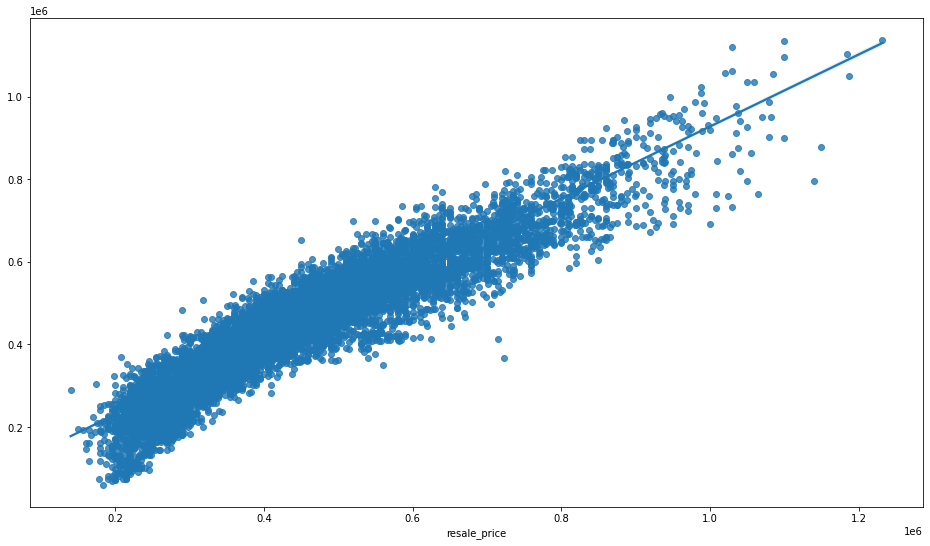

In [77]:
plt.figure(figsize = (16,9))
sns.regplot( x = y_train, y = predictions)

# EDA


In [78]:
df = X_train.copy()
df['resale_price'] = y_train # data analysis to be done only on 2020 data
df_test = X_test.copy()
df_test['resale_price'] = y_test

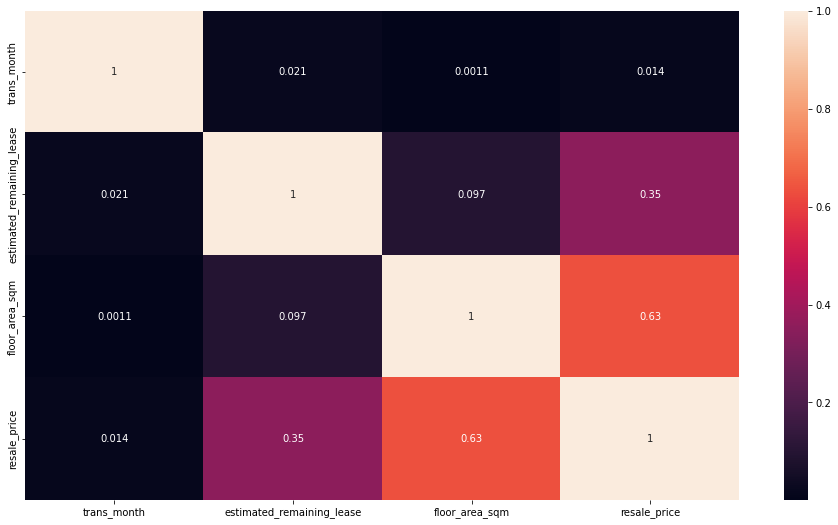

In [79]:
plt.figure(figsize = (16,9))
sns.heatmap(df.corr(), annot = True) 

1. As expected floor area and remaining lease length is correlated with resale price.
2. No issue with multicollinearity amongst the numerical features

### HDBscan :
Using HDBscan to find multicollinearity between features

### reference :
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [80]:
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [81]:
df_dummy = pd.get_dummies(data = df , columns = ['town','flat_type','flat_model'])

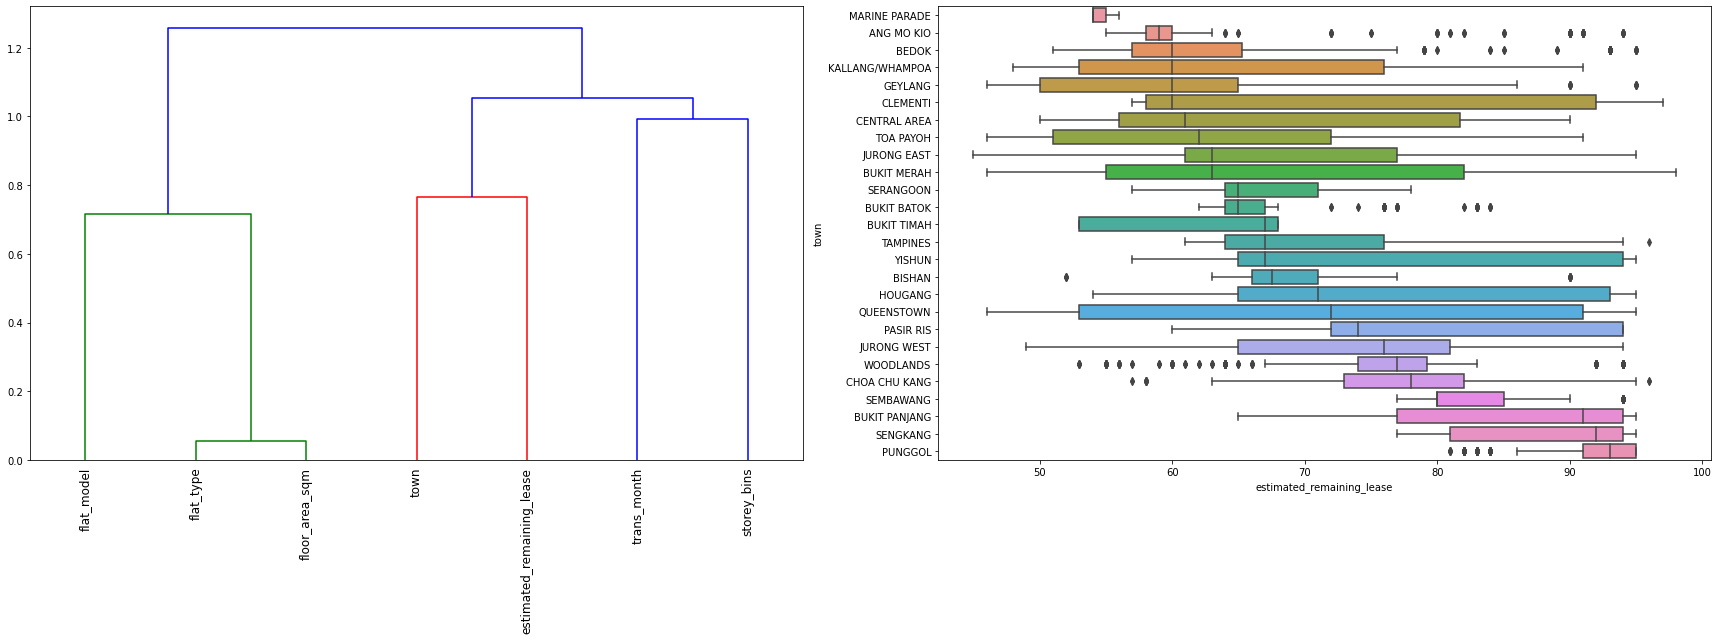

In [82]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24, 9))
corr = spearmanr(df.drop(columns = 'resale_price', axis = 'columns')).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels= df.drop(columns = 'resale_price', axis = 'columns').columns , ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))


sns.boxplot(y="town", x="estimated_remaining_lease", data=df , orient = 'h' , ax = ax2 , order = df.groupby('town').agg(median_age = ('estimated_remaining_lease','median')).reset_index().sort_values(by = 'median_age').town)


fig.tight_layout()
plt.show()

1. According to the dendogram , we can see that flat types and floor areas sqm are correlated, which may be because the type of flat (3/4/5 rooms) is related to the size of the flat.

2. Town area is correlated with remaining lease, this may be because some towns are developed at different times.

3. We observe that there is a distinct difference in the distribution of the remaining lease of flats sold in each town.

4. This may be the case that some estates are more "matured" than others. E.g. Flats sold in pongol tends to be newer, as there are more flats that has reached their MOP requirements of 5 years.

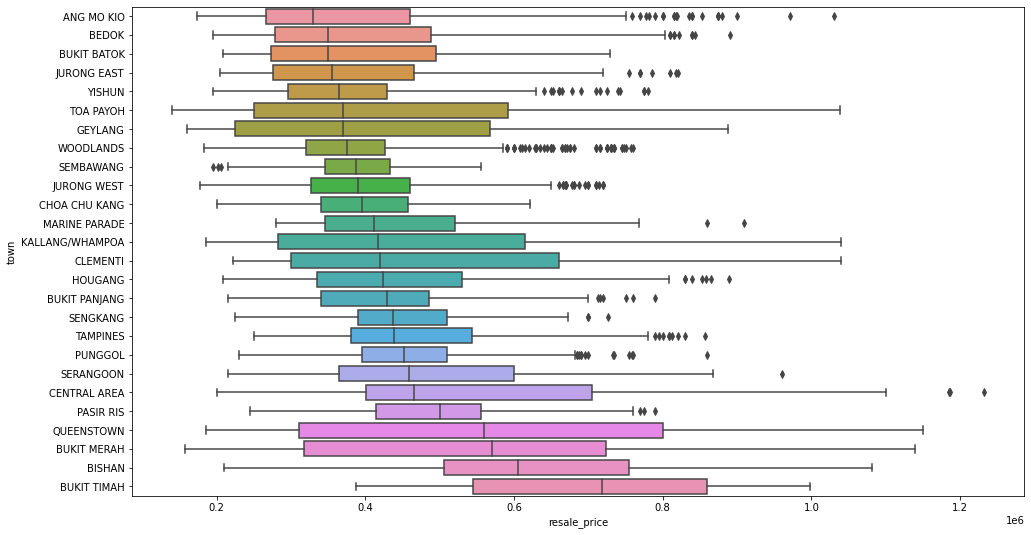

In [83]:
plt.figure(figsize=(16,9))
sns.boxplot(y="town", x="resale_price", data=df , orient = 'h' , order = df.groupby('town').agg(median_price= ('resale_price','median')).reset_index().sort_values(by = 'median_price').town)

In [90]:
df.head(5)

,town,trans_month,estimated_remaining_lease,flat_type,flat_model,storey_bins,floor_area_sqm,resale_price
year_month,,,,,,,,
2020-01-01,YISHUN,1,94,5 ROOM,Improved,10s,112.0,500000.0
2020-01-01,BEDOK,1,56,5 ROOM,Standard,25s,120.0,615000.0
2020-01-01,WOODLANDS,1,72,3 ROOM,Simplified,5s,64.0,255000.0
2020-01-01,TOA PAYOH,1,49,3 ROOM,Improved,5s,67.0,265000.0
2020-01-01,YISHUN,1,92,5 ROOM,DBSS,15s,112.0,715000.0


1. We can observe that the distribution for the property prices differs slightly between each zone.
2. There are numerous outliers in each town. 

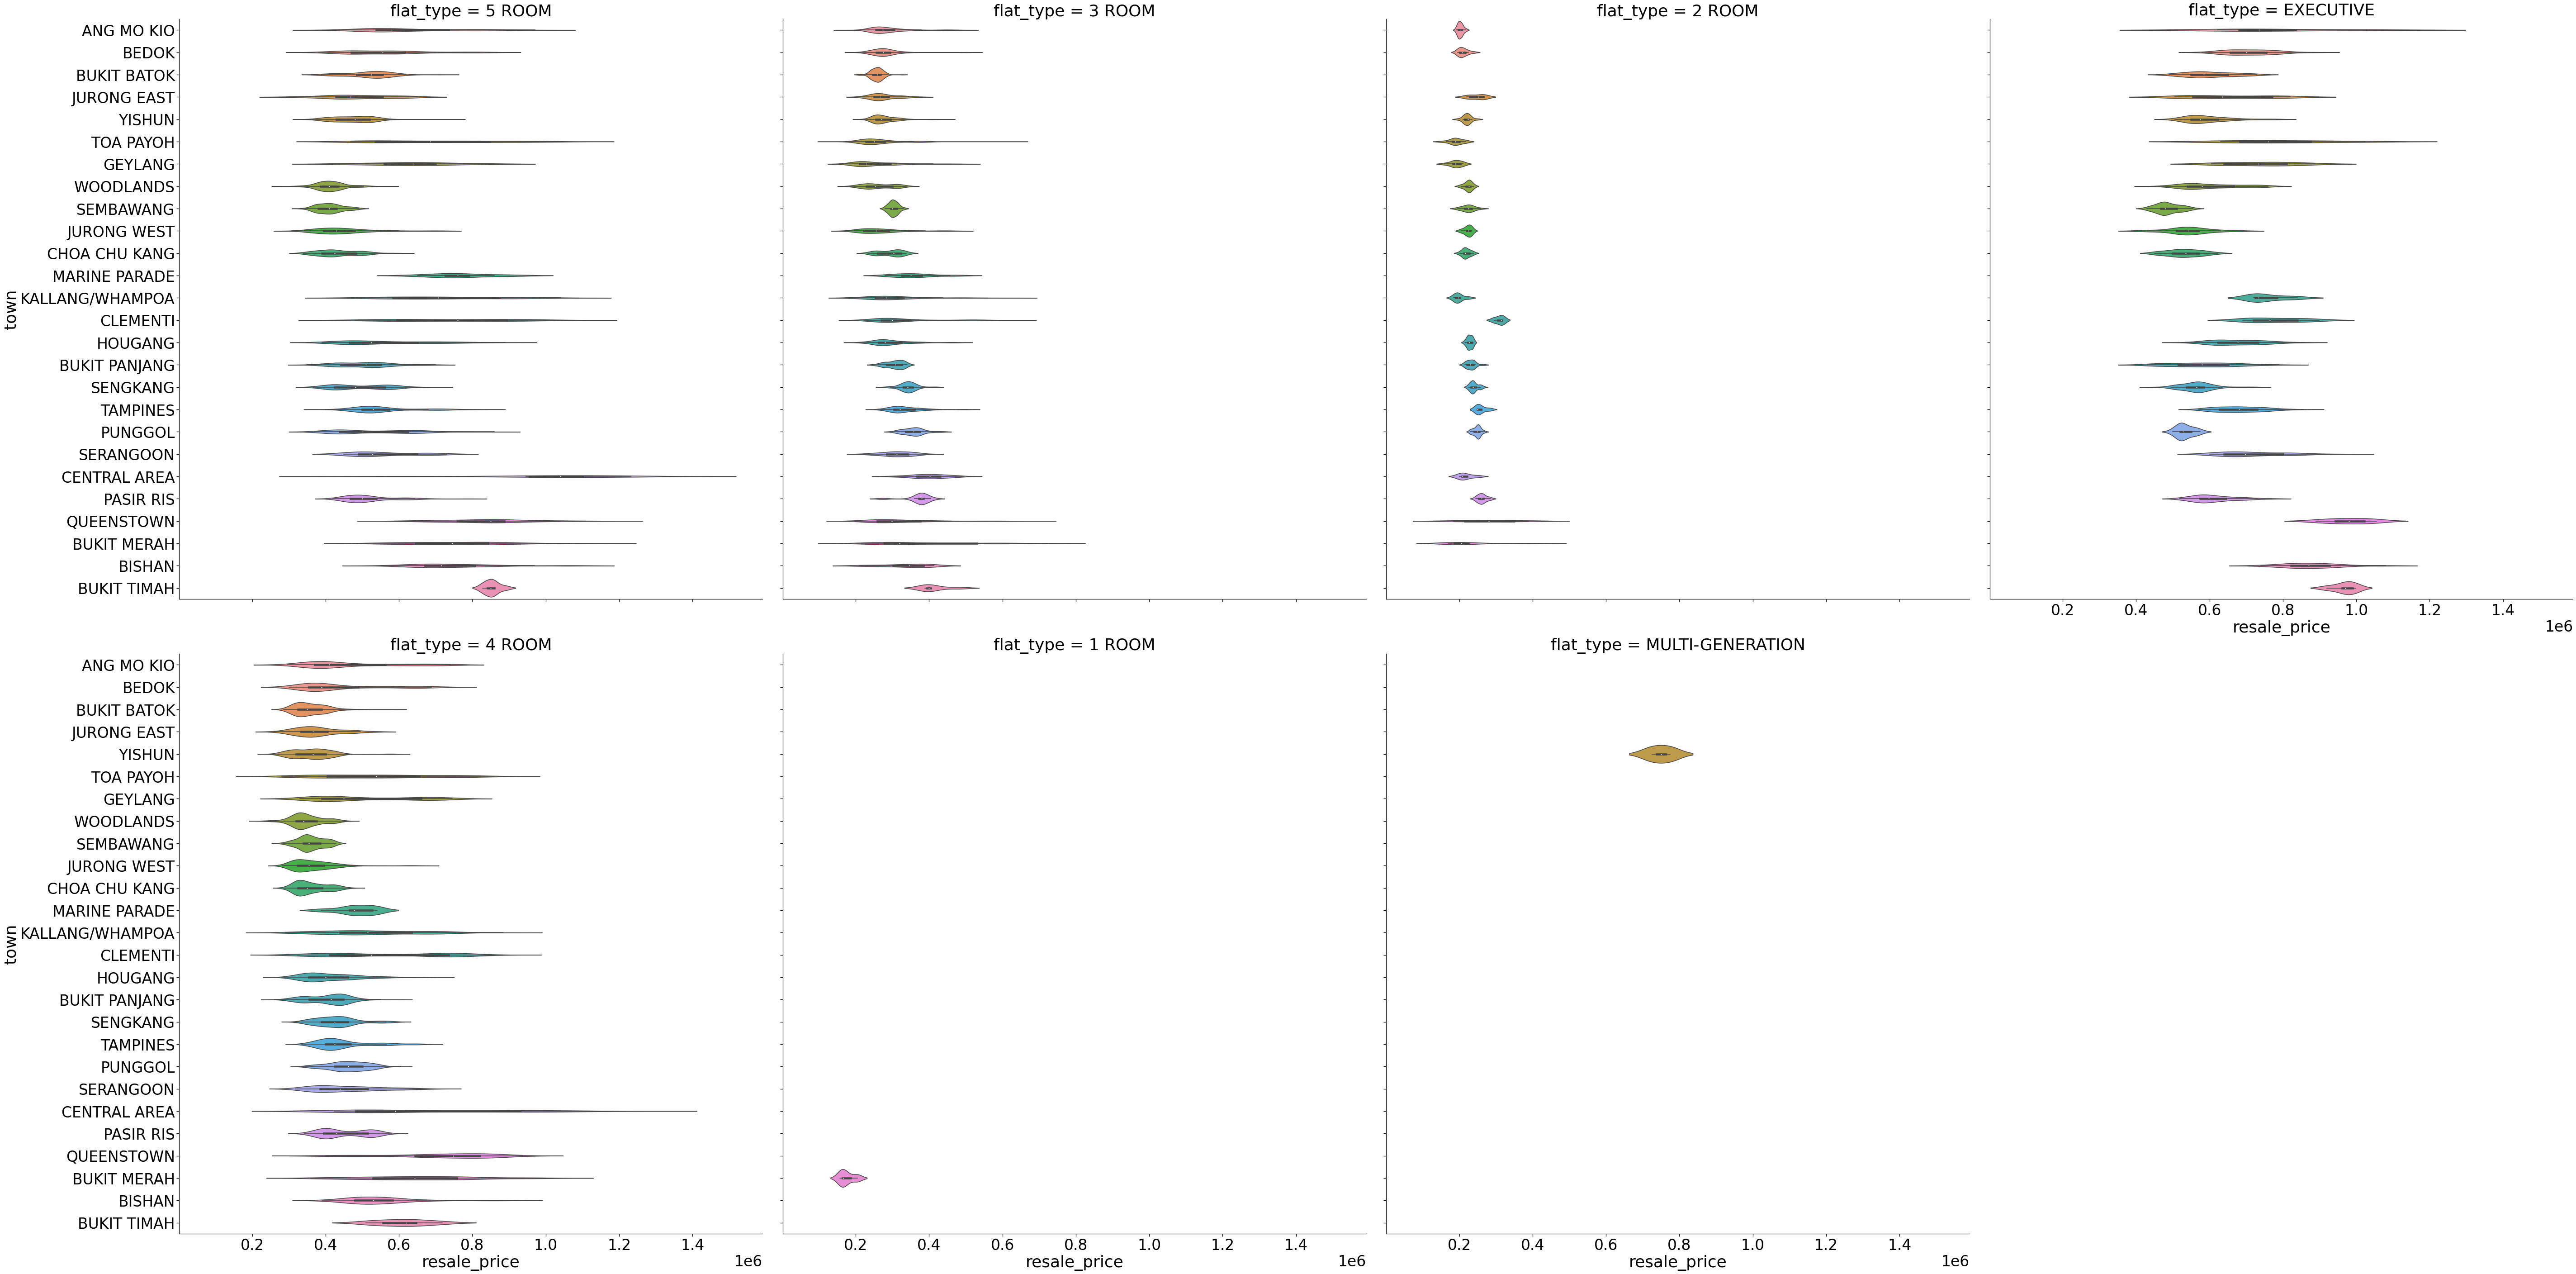

In [99]:
with sns.plotting_context(context = 'notebook' , font_scale=3):
  sns.catplot(
      data=df, y='town', x='resale_price',
      col='flat_type', kind='violin',order = df.groupby('town').agg(median_price = ('resale_price','median')).reset_index().sort_values(by = 'median_price').town
      ,orient = 'h', col_wrap=4 , height = 20
  )

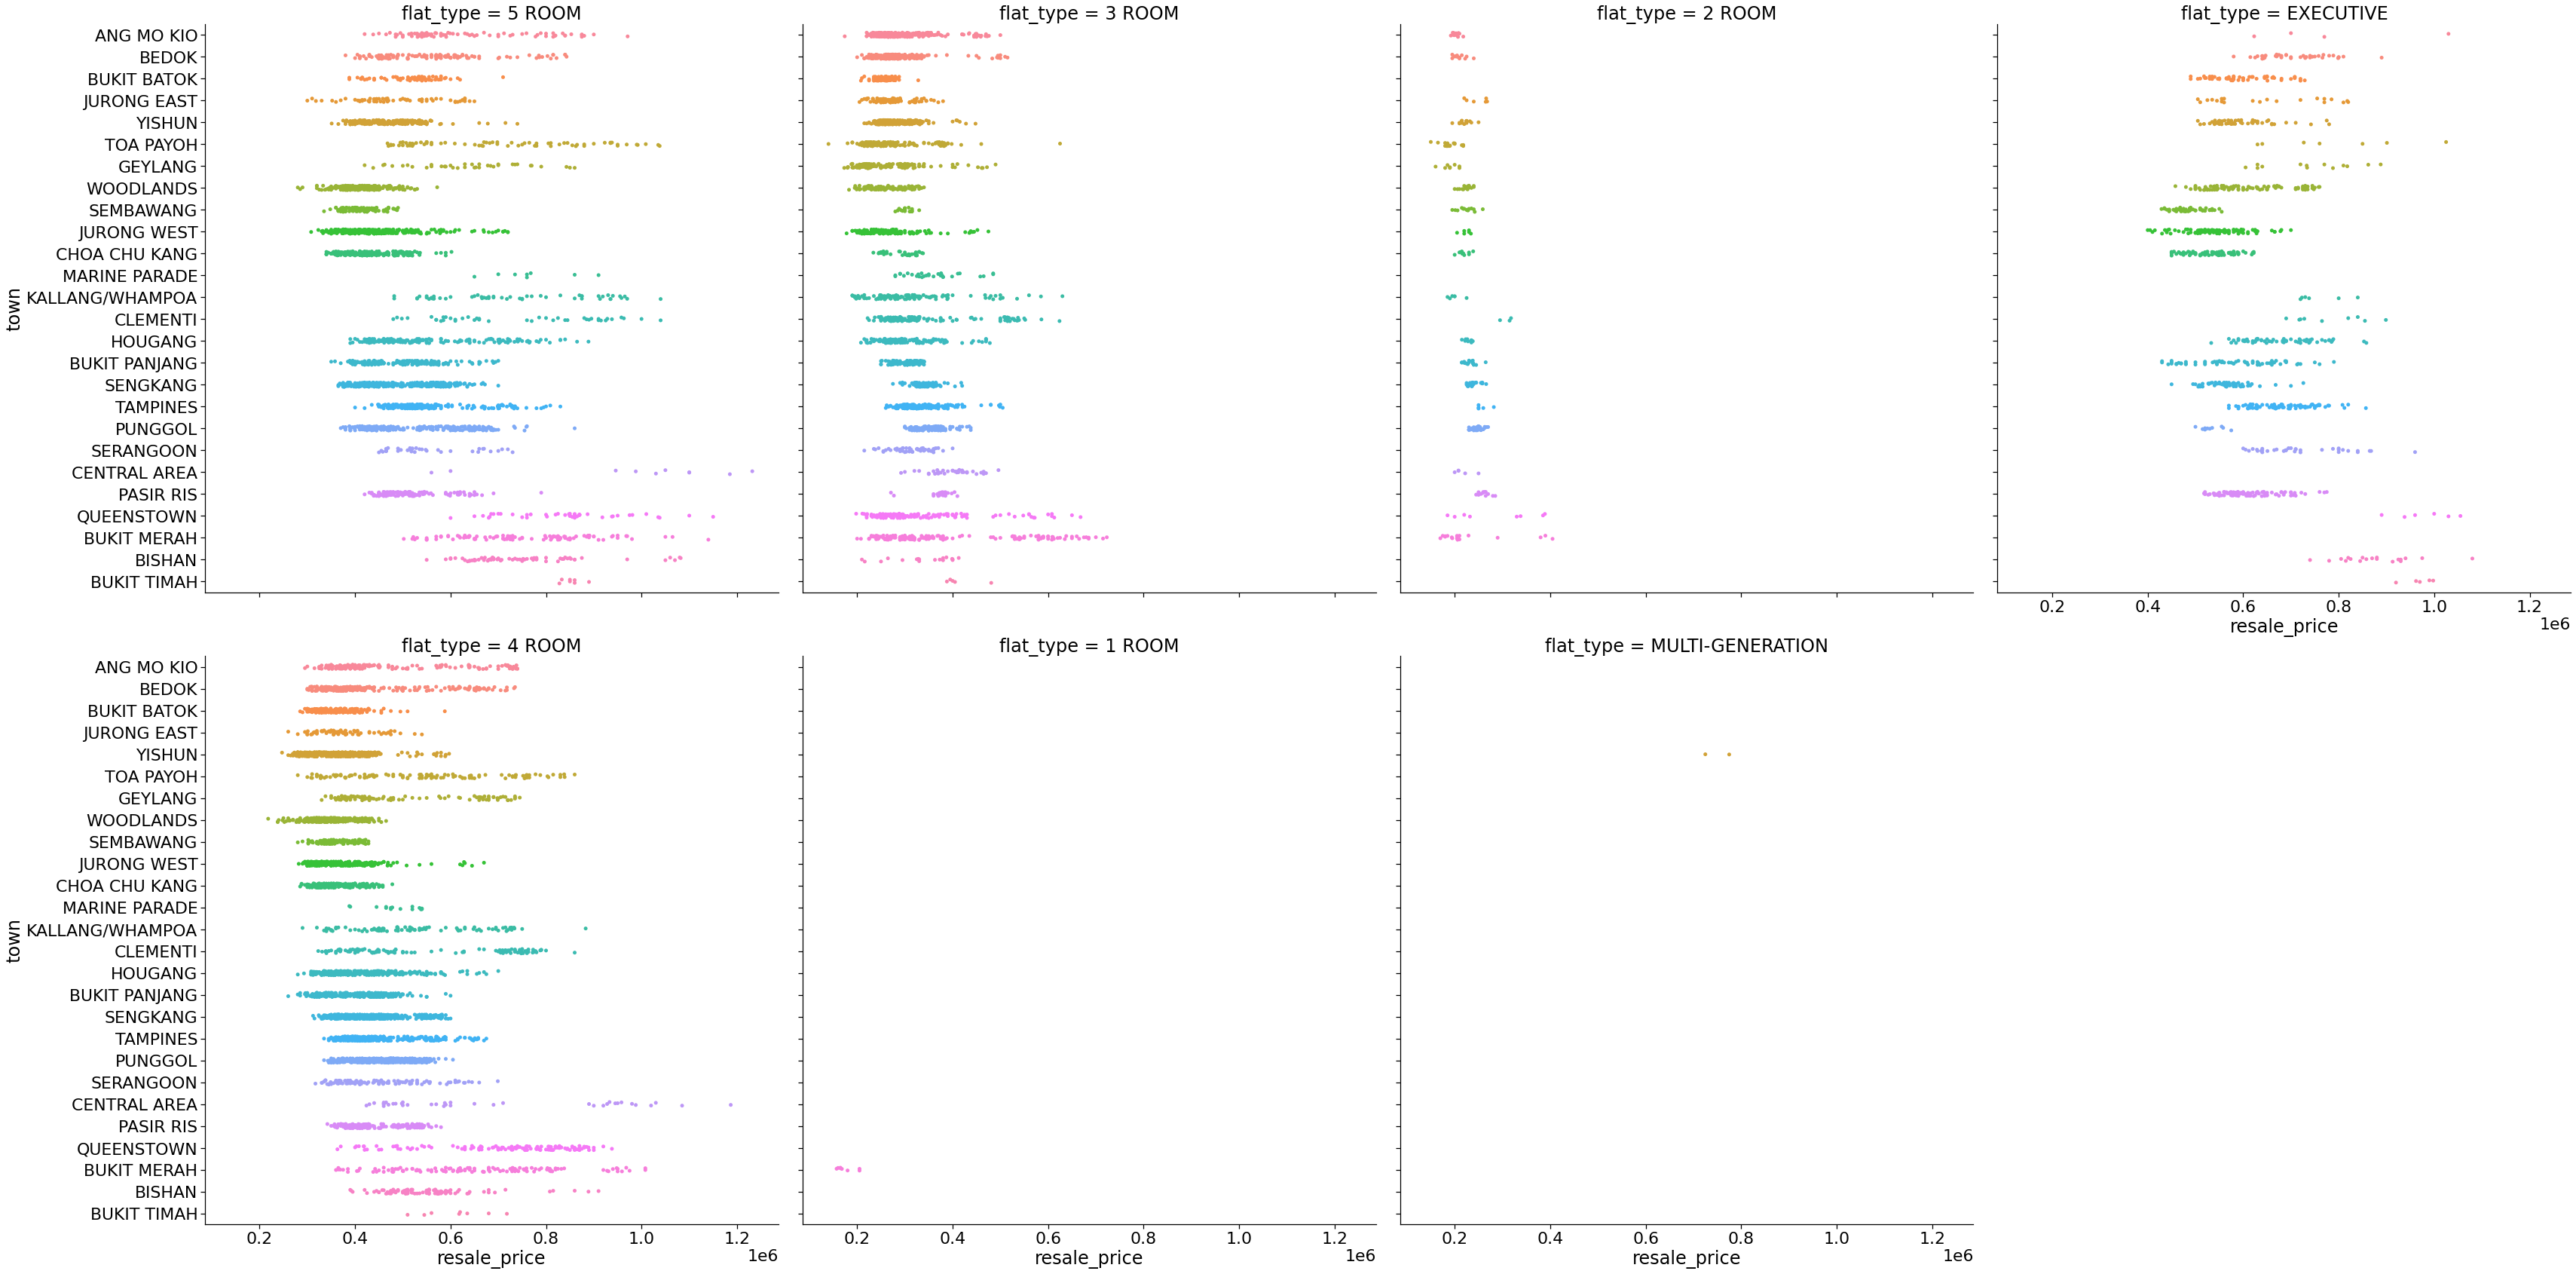

In [85]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(
      data=df, y='town', x='resale_price',
      col='flat_type', kind='strip' ,order = df.groupby('town').agg(median_price = ('resale_price','median')).reset_index().sort_values(by = 'median_price').town
      ,orient = 'h', col_wrap=4 , height = 12
  )

1. Even amongst the different flat types, the resale price distribution of the flats differs between each town.
2. Lets see if this pattern holds when adjusted for the size of the property by looking at area per square metre.

In [100]:
df['price_per_sqm'] = df.resale_price/df.floor_area_sqm

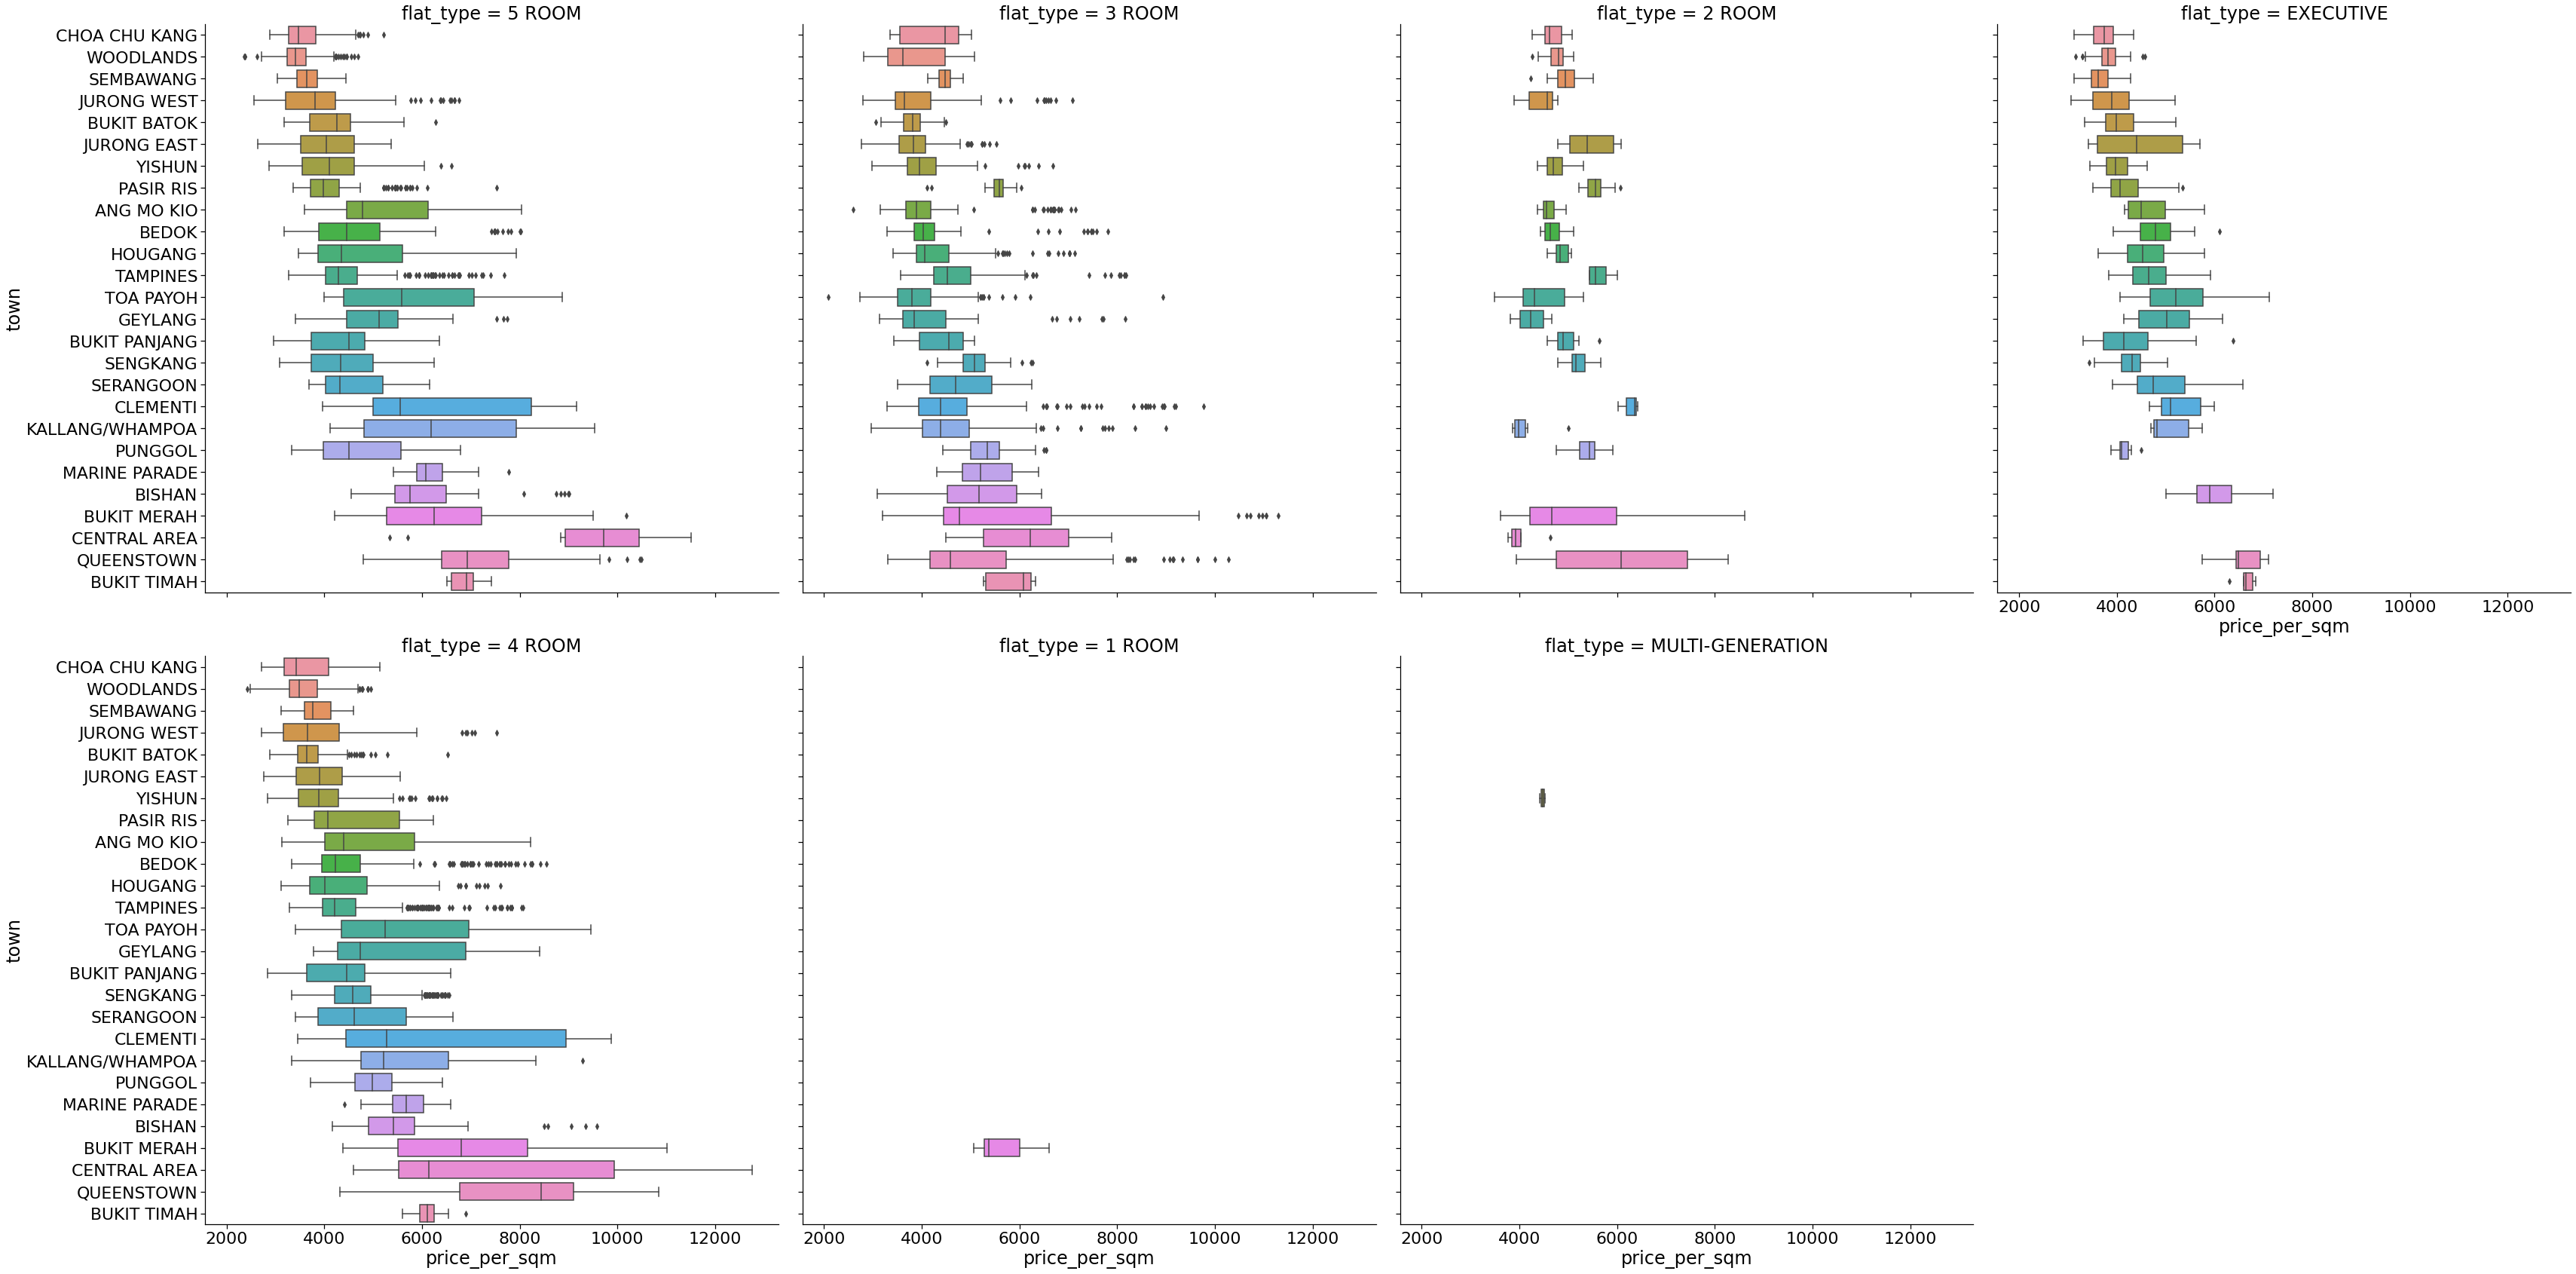

In [101]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(
      data=df, y='town', x='price_per_sqm',
      col='flat_type', kind='box', order = df.groupby('town').agg(median_price = ('price_per_sqm','median')).reset_index().sort_values(by = 'median_price').town
      ,orient = 'h', col_wrap=4 , height = 12
  )

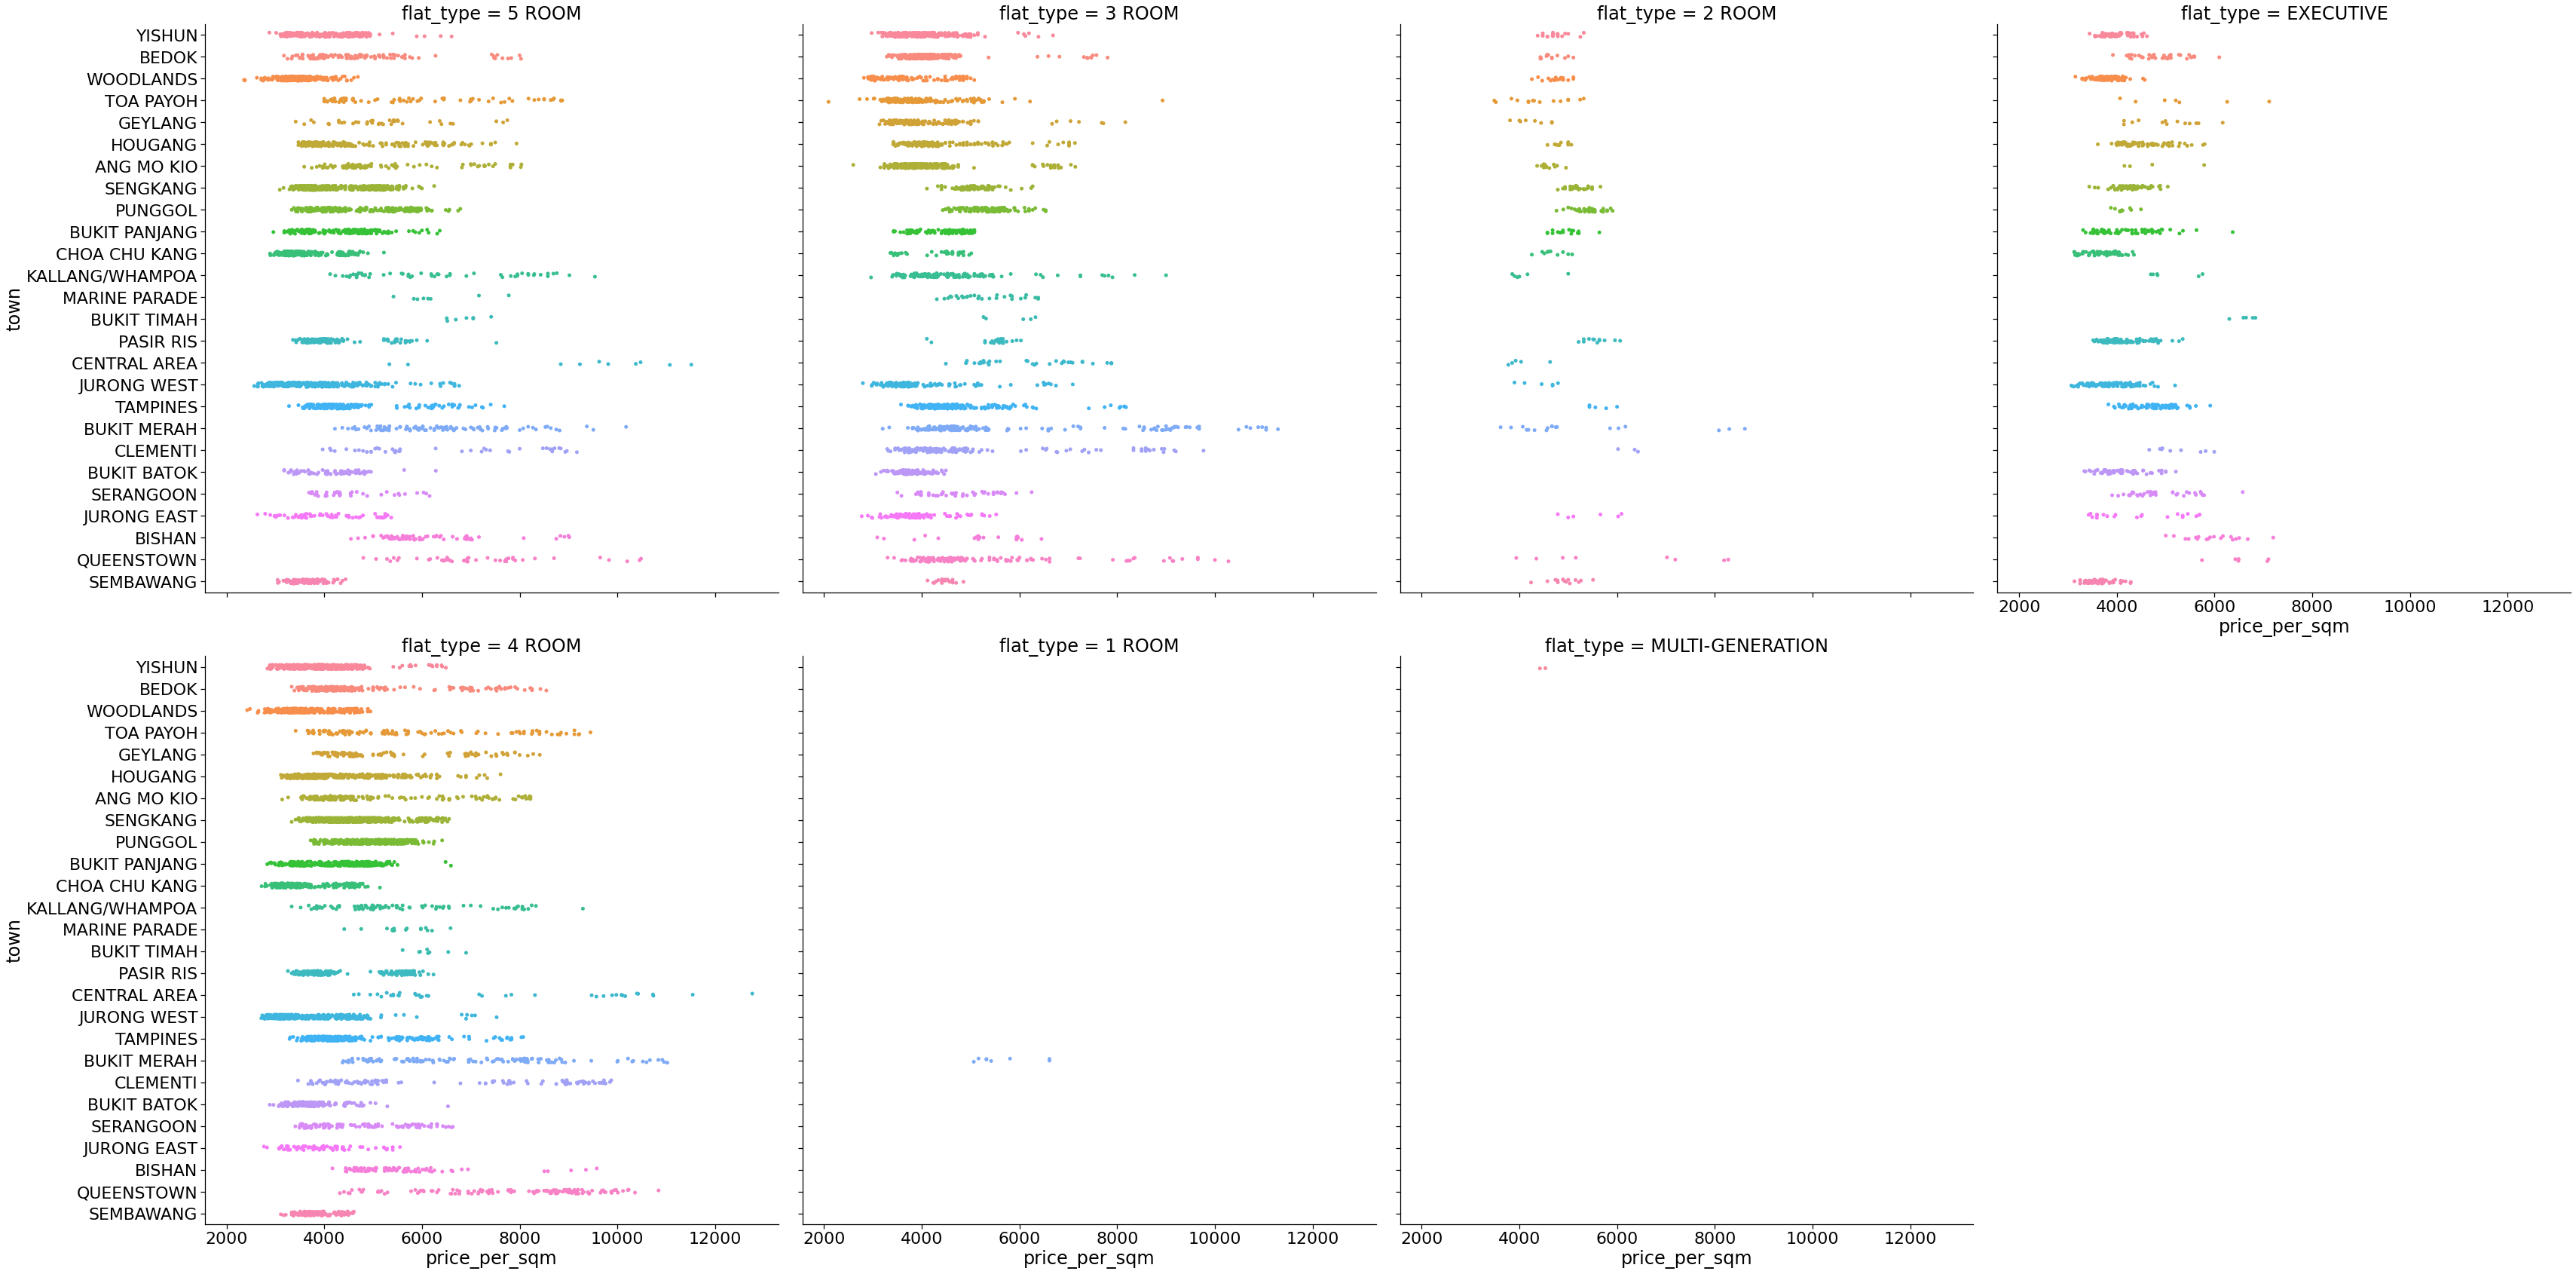

In [102]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(
      data=df, y='town', x='price_per_sqm',
      col='flat_type', kind='strip'
      ,orient = 'h', col_wrap=4 , height = 12
  )

In [103]:
mask = df.flat_type == '1 ROOM'
len(df[mask])

8

In [104]:
mask = df.flat_type == 'MULTI-GENERATION'
len(df[mask])

2

1. We still see a different distribution for price per sqm for houses in different towns.
2. Dollar per square metre for different flat types in the same town seems fairly similar.
3. According to the strip plot, flat_type = 1 Room and, multi-generation seems to suggest that we have very little data (<10) for these transactions

Action : 
1. t-test and ANOVA test to test for the mean and variance of price per sqm between flat types
2. Remove flat_type = 1 room flat and multi-generation and not include them in our regression.

In [105]:
pd.crosstab(df.town,df.flat_type)

flat_type,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI-GENERATION
town,,,,,,,
ANG MO KIO,0,12,319,162,84,4,0
BEDOK,0,12,323,248,122,39,0
BISHAN,0,0,18,93,68,19,0
BUKIT BATOK,0,0,121,172,69,56,0
BUKIT MERAH,8,18,169,126,103,0,0
BUKIT PANJANG,0,17,104,330,173,64,0
BUKIT TIMAH,0,0,5,8,7,5,0
CENTRAL AREA,0,5,36,39,10,0,0
CHOA CHU KANG,0,10,34,238,199,77,0


1. We have some categories that have very few data points.

Action:
We will be removing these data points, and will not include them in our modelling.

In [106]:
df.reset_index(inplace = True)
df_test.reset_index(inplace = True)

In [107]:
def remove_flat_type(df,df_test):
  town_list = df.town.unique().tolist()
  flat_type_list = df.flat_type.unique().tolist()

  for town in town_list:
    for flat_type in flat_type_list:

      mask = df.town == town
      mask1 = df.flat_type == flat_type

      mask2 = df_test.town == town
      mask3 = df_test.flat_type == flat_type

      if len(df[mask&mask1]) < 10:
        df.drop(df[mask&mask1].index, inplace = True)
        df_test.drop(df_test[mask2&mask3].index , inplace = True)

  return df,df_test

In [108]:
df,df_test = remove_flat_type(df,df_test)

In [109]:
pd.crosstab(df.town,df.flat_type)

flat_type,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE
town,,,,,
ANG MO KIO,12,319,162,84,0
BEDOK,12,323,248,122,39
BISHAN,0,18,93,68,19
BUKIT BATOK,0,121,172,69,56
BUKIT MERAH,18,169,126,103,0
BUKIT PANJANG,17,104,330,173,64
CENTRAL AREA,0,36,39,10,0
CHOA CHU KANG,10,34,238,199,77
CLEMENTI,0,155,111,43,0


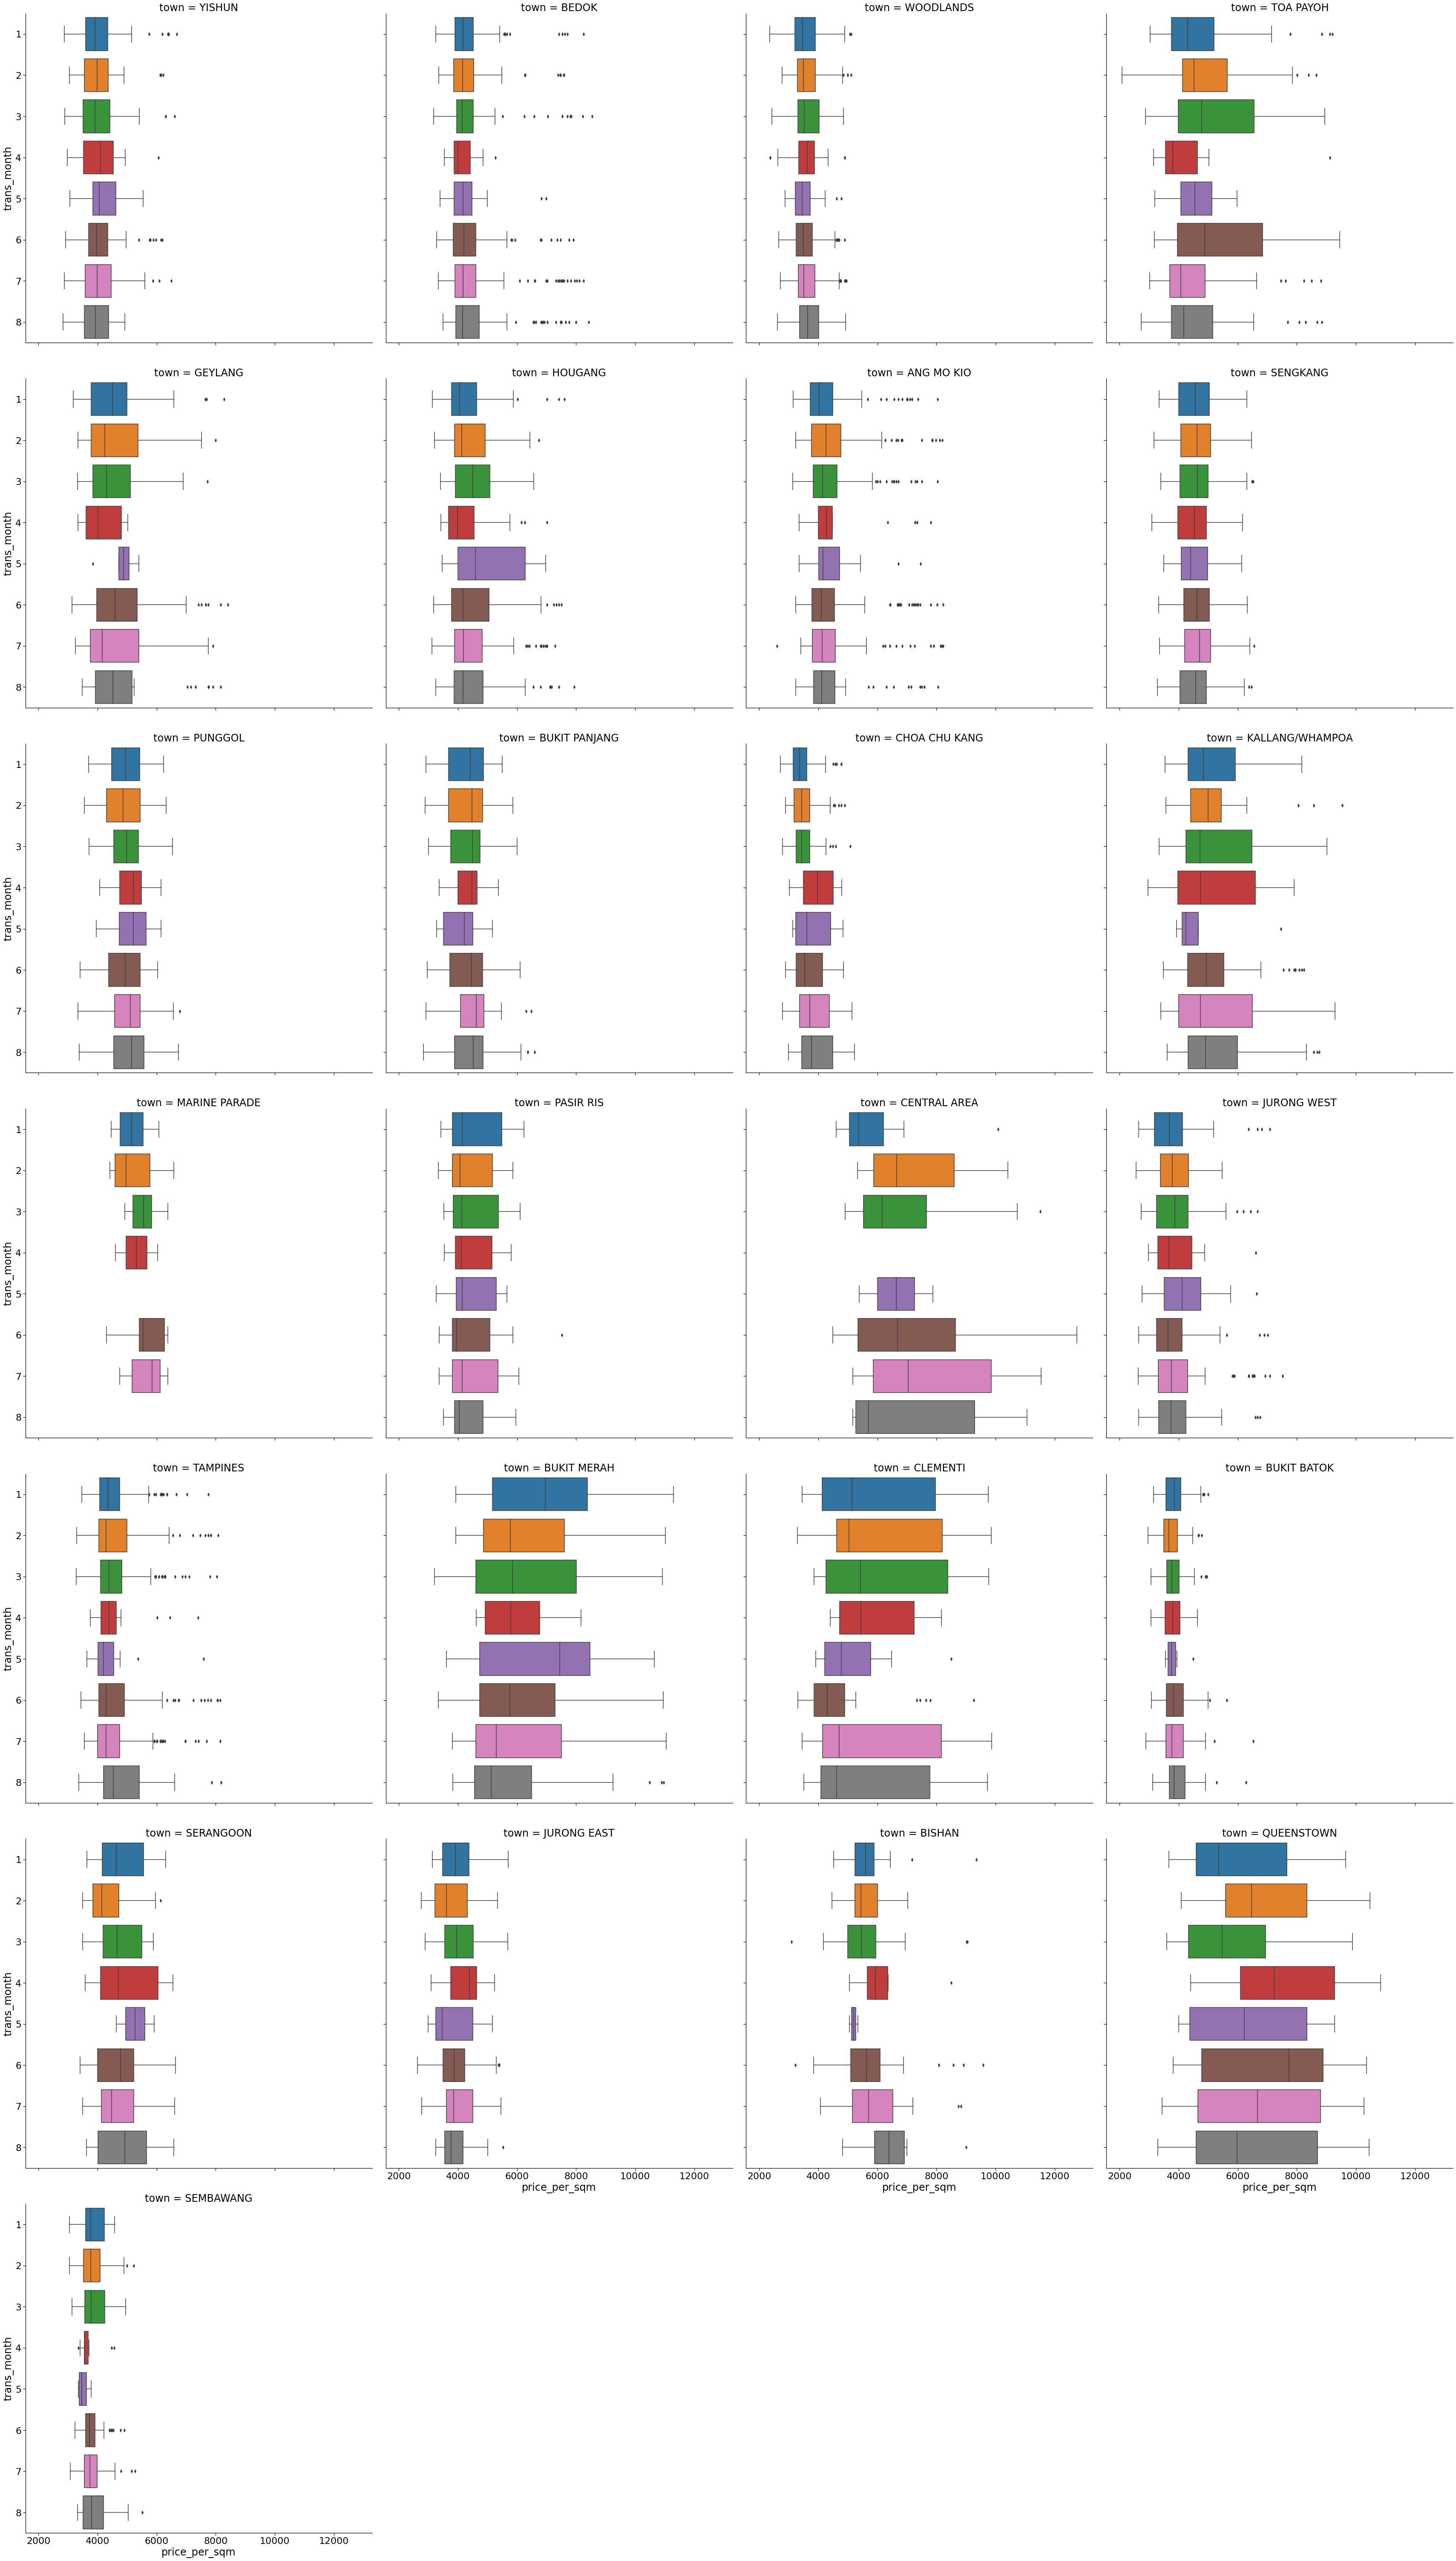

In [141]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(data = df , y = 'trans_month', x = 'price_per_sqm' , orient = 'h', kind = 'box' ,col = 'town' , col_wrap = 4, height = 12)

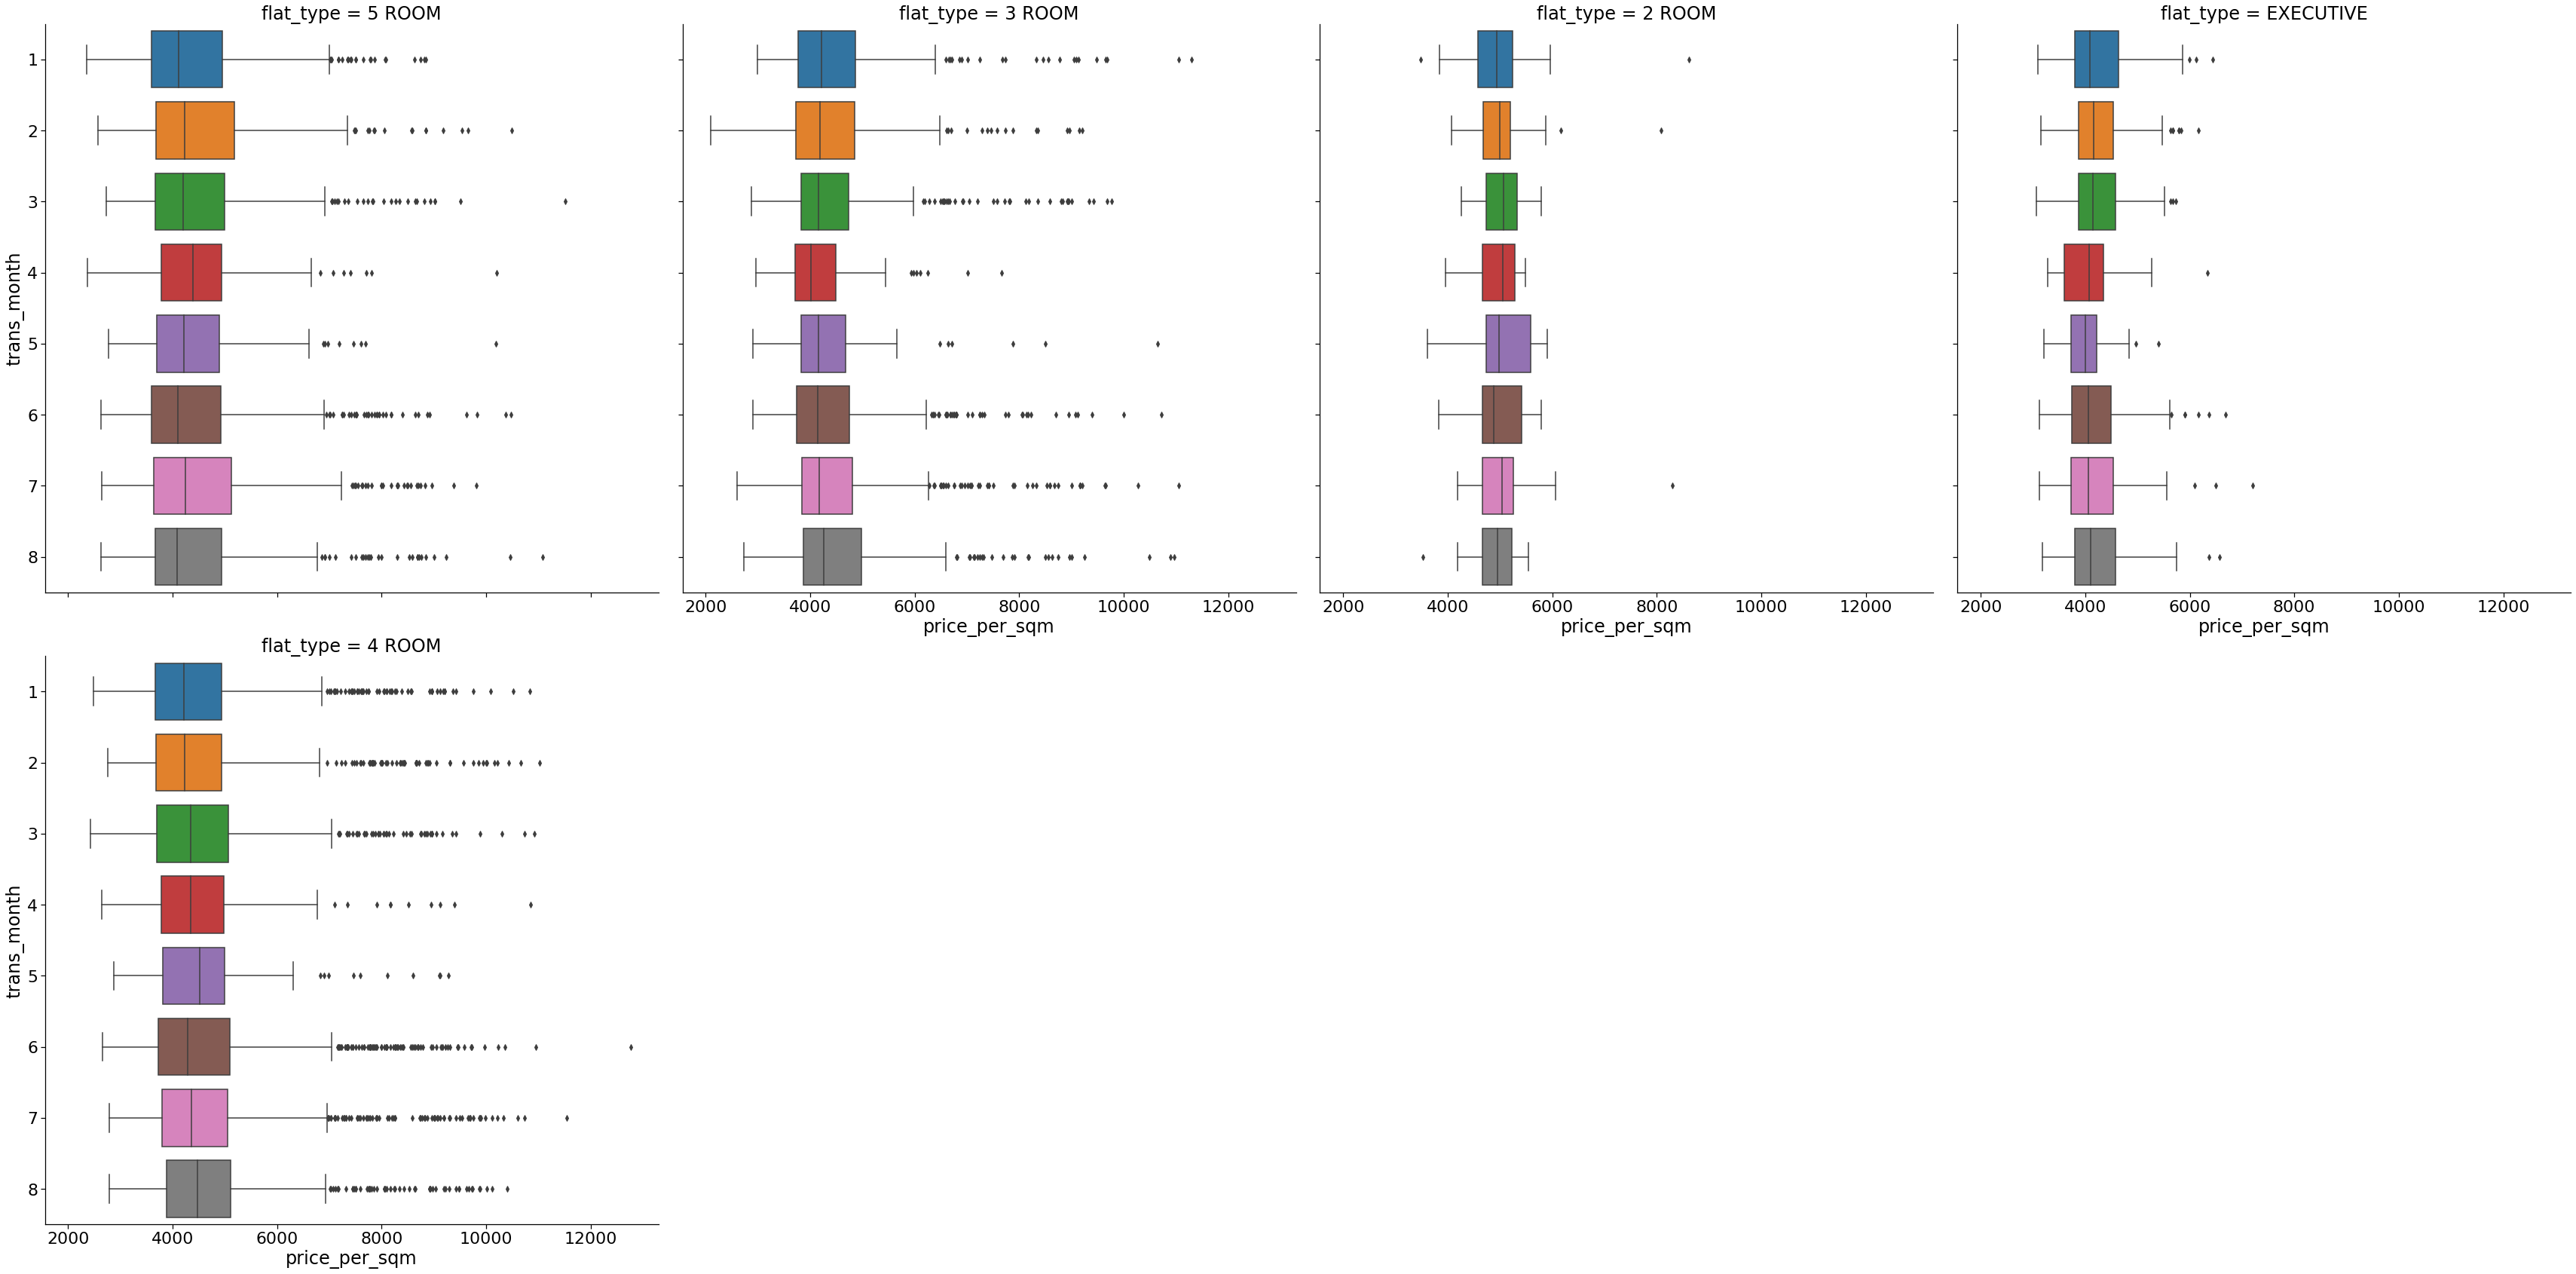

In [142]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(data = df , y = 'trans_month', x = 'price_per_sqm' , orient = 'h', kind = 'box' ,col = 'flat_type' , col_wrap = 4, height = 12)

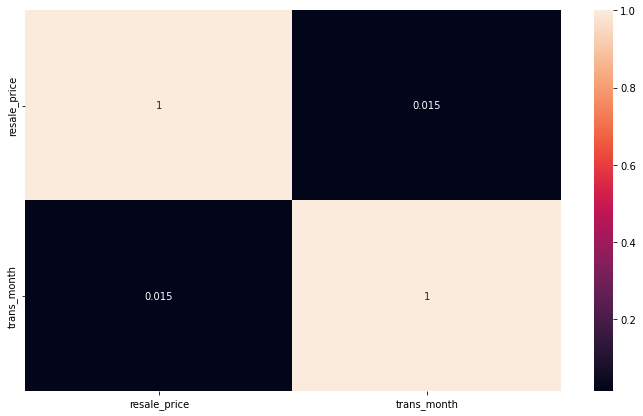

In [147]:
plt.figure(figsize = (12,7))
sns.heatmap(df[['resale_price','trans_month']].corr(),annot = True)

1. Prices of resale home in the short term has a weak correlation with which month the property was being sold.

In [136]:
for town in df.town.unique():
  mask = df['town'] == town
  print(f'Town :{town}')
  print('-------------------------------------------------------------------------------')
  print(df[mask].groupby('trans_month').agg({'price_per_sqm':['min','mean','median','max']}))
  print('-------------------------------------------------------------------------------')

Town :YISHUN
-------------------------------------------------------------------------------
            price_per_sqm                                       
                      min         mean       median          max
trans_month                                                     
1             2879.807692  4026.598103  3911.745620  6686.567164
2             3048.076923  4005.916896  3978.260870  6217.391304
3             2884.615385  3979.881251  3907.738095  6607.142857
4             2972.972973  4065.964001  4098.465473  6053.571429
5             3057.692308  4166.870947  4062.500000  5543.478261
6             2917.431193  4028.462396  3967.391304  6194.029851
7             2877.049180  4026.828546  3984.375000  6489.130435
8             2836.538462  3945.797558  3928.571429  4925.373134
-------------------------------------------------------------------------------
Town :BEDOK
-------------------------------------------------------------------------------
            price_pe

1. Even when the data is segregated based on the different town, the min/mean/median/max deviates only a small amount between months

In [149]:
pd.crosstab(df.town,df.storey_bins)

storey_bins,10s,15s,20s,25s,30s,35s,5s,>35
town,,,,,,,,
ANG MO KIO,125,147,34,12,6,0,253,0
BEDOK,193,218,18,7,0,0,308,0
BISHAN,37,43,10,2,2,1,103,0
BUKIT BATOK,83,84,20,12,0,0,219,0
BUKIT MERAH,80,109,33,32,12,4,144,2
BUKIT PANJANG,111,234,65,37,8,1,232,0
CENTRAL AREA,18,21,15,3,1,3,18,6
CHOA CHU KANG,106,168,20,5,0,0,259,0
CLEMENTI,64,53,26,20,3,11,125,7


1. We have very few data points in some towns where the properties are between 20 storey to 30storey and >35 storey.
2. We will first combine 20s and 25s into 1 category, and 30s and 35s into a single category

In [150]:
def join_storey(df):
  X = df.storey_bins
  condlist = [X == '5s' , X == '10s', 
              X == '15s', X == '20s',
              X == '25s', X == '30s',
              X == '35s', X == '>35']

  choicelist = ['5s' , '10s', 
              '10s-20s','10s-20s',
              '>20s', '>20s',
              '>20s', '>20s']
  df.storey_bins  = np.select(condlist,choicelist)

  return df

In [151]:
df = join_storey(df)
df_test = join_storey(df_test)

In [152]:
pd.crosstab(df.town,df.storey_bins)

storey_bins,10s,10s-20s,5s,>20s
town,,,,
ANG MO KIO,125,181,253,18
BEDOK,193,236,308,7
BISHAN,37,53,103,5
BUKIT BATOK,83,104,219,12
BUKIT MERAH,80,142,144,50
BUKIT PANJANG,111,299,232,46
CENTRAL AREA,18,36,18,13
CHOA CHU KANG,106,188,259,5
CLEMENTI,64,79,125,41


In [158]:
pd.crosstab(df.town,df.flat_model)

flat_model,Apartment,DBSS,Improved,Maisonette,Model A,Model A2,New Generation,Premium Apartment,Premium Apartment Loft,Simplified,Standard,Type S1
town,,,,,,,,,,,,
ANG MO KIO,0,25,70,0,66,0,407,0,0,0,0,0
BEDOK,23,39,183,14,72,0,327,21,0,28,29,0
BISHAN,0,15,55,15,61,0,0,0,0,35,0,0
BUKIT BATOK,20,0,69,36,143,0,92,0,0,52,0,0
BUKIT MERAH,0,0,147,0,147,0,35,0,0,0,72,0
BUKIT PANJANG,24,0,153,19,365,0,0,102,0,16,0,0
CENTRAL AREA,0,0,41,0,16,0,0,0,0,0,0,14
CHOA CHU KANG,39,0,138,25,262,12,0,74,0,0,0,0
CLEMENTI,0,60,30,0,48,0,168,0,0,0,0,0


In [153]:
def remove_flat_model(df,df_test):
  town_list = df.town.unique().tolist()
  flat_model_list = df.flat_model.unique().tolist()

  for town in town_list:
    for flat_model in flat_model_list:

      mask = df.town == town
      mask1 = df.flat_model == flat_model

      mask2 = df_test.town == town
      mask3 = df_test.flat_model == flat_model

      if len(df[mask&mask1]) < 10:
        df.drop(df[mask&mask1].index, inplace = True)
        df_test.drop(df_test[mask2&mask3].index , inplace = True)

  return df,df_test

In [154]:
df , df_test = remove_flat_model(df,df_test)

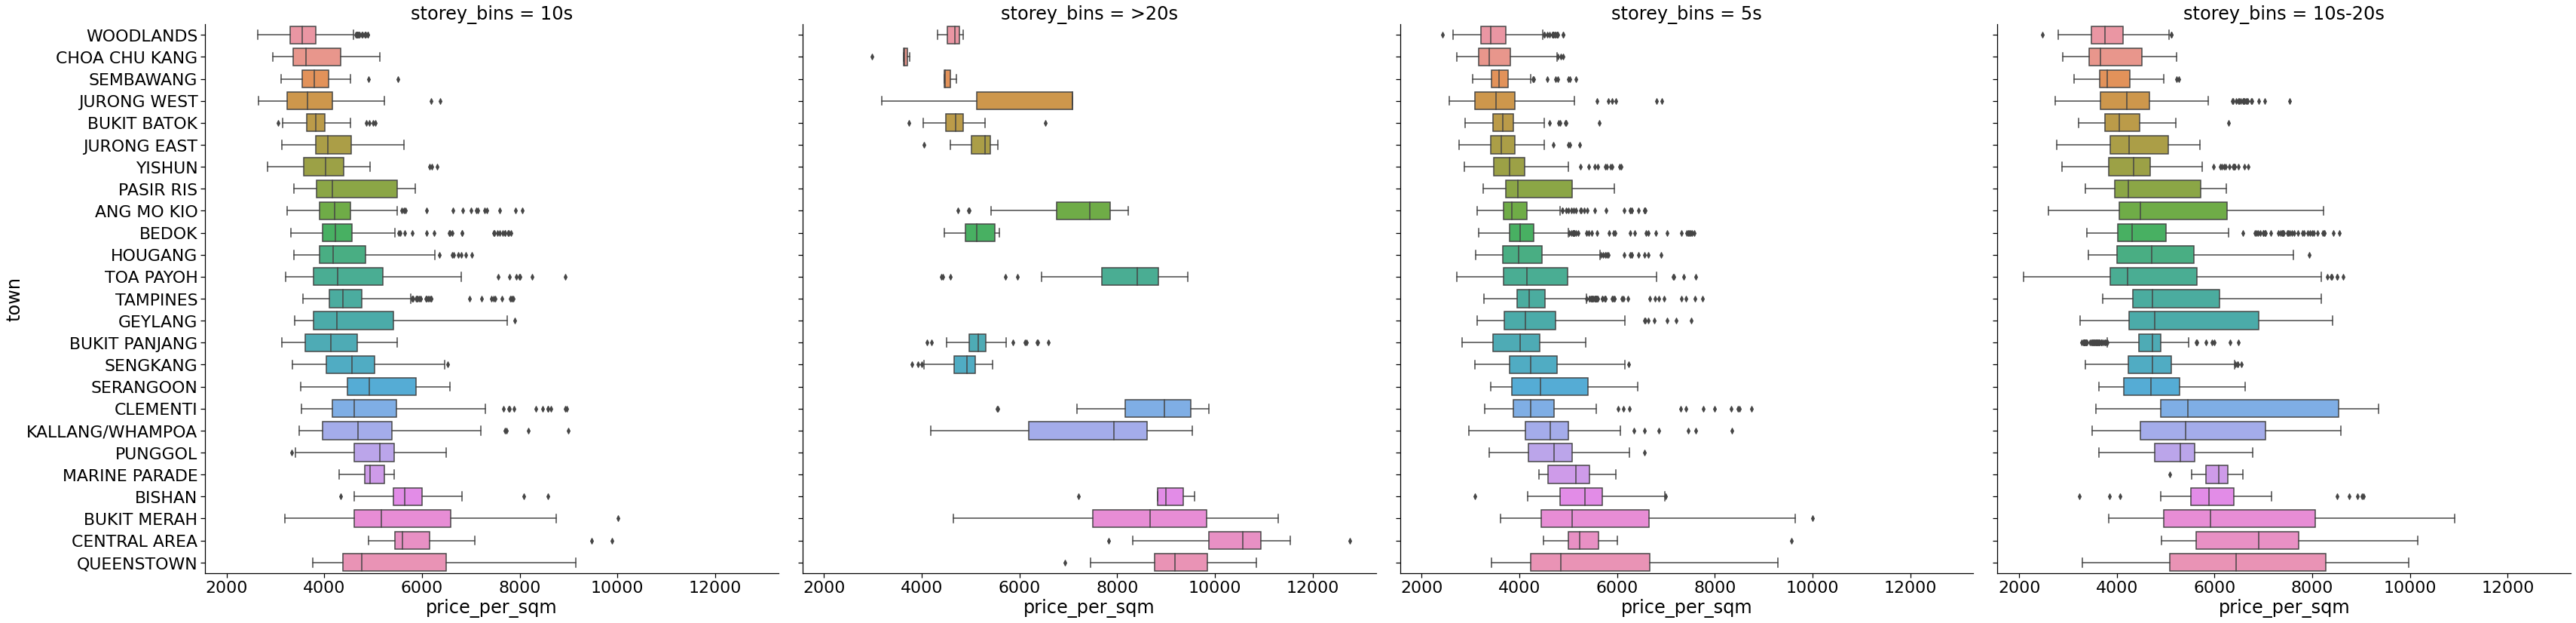

In [156]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(
      data=df, y='town', x='price_per_sqm',
      col='storey_bins', kind='box' , order = df.groupby('town').agg(median_price = ('price_per_sqm','median')).reset_index().sort_values(by = 'median_price').town
      ,orient = 'h', col_wrap=4 , height = 12
  )

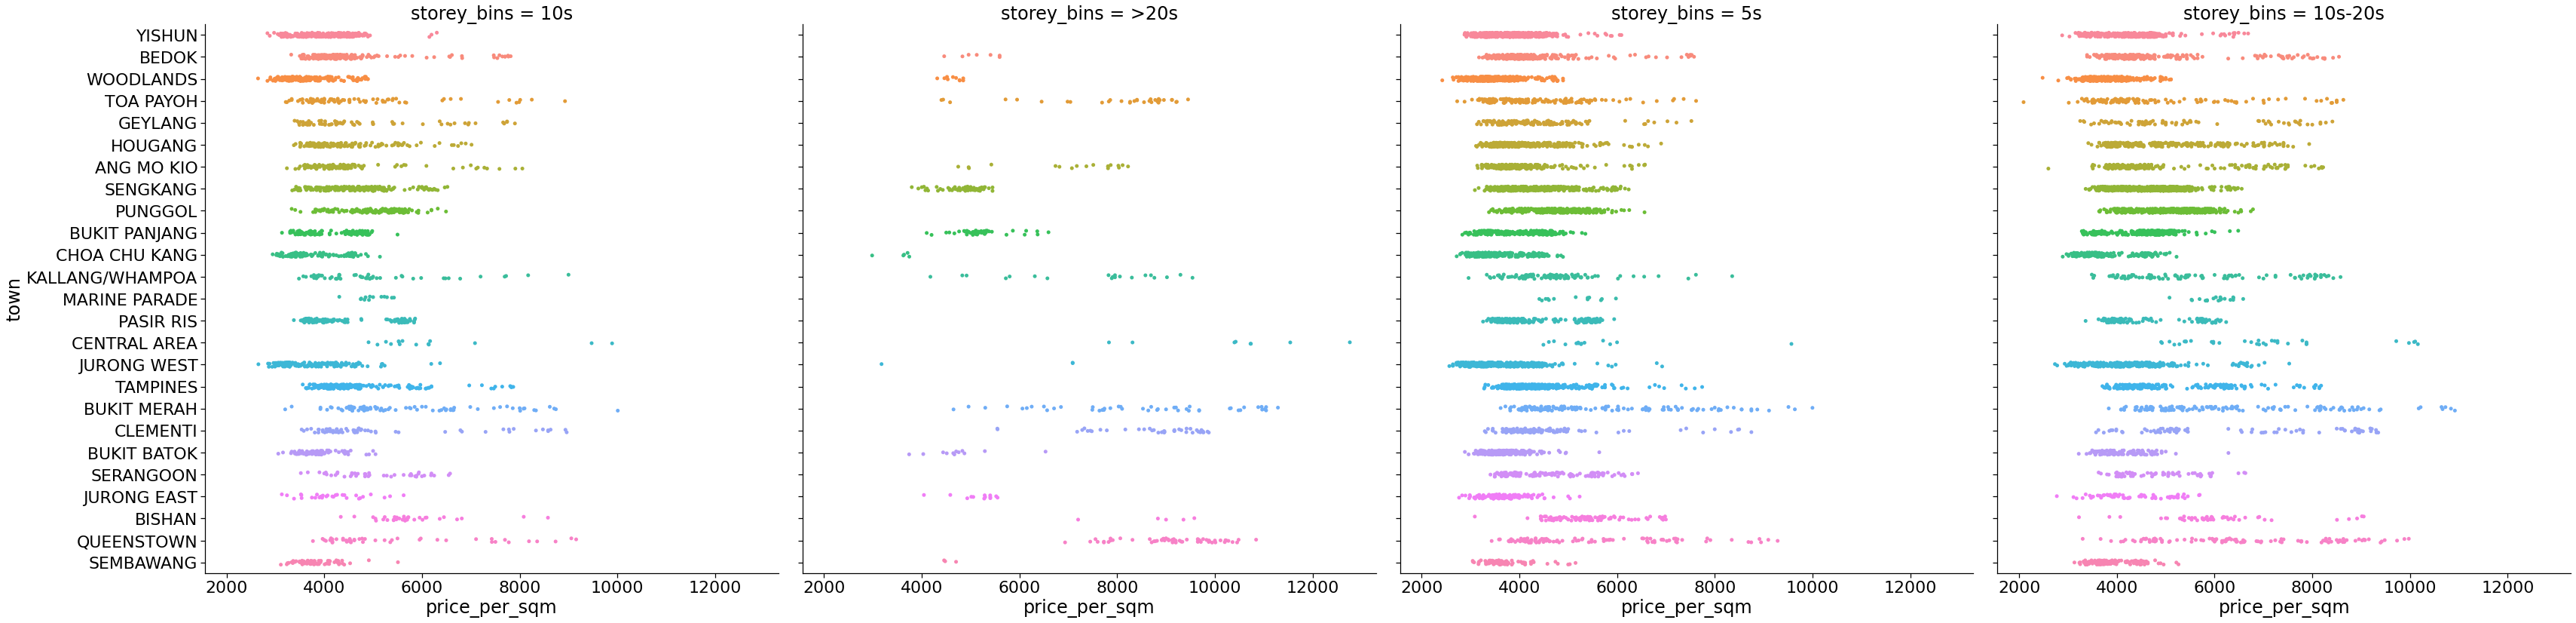

In [157]:
with sns.plotting_context(context = 'notebook' , font_scale=2):
  sns.catplot(
      data=df, y='town', x='price_per_sqm',
      col='storey_bins', kind='strip'
      ,orient = 'h', col_wrap=4 , height = 12
  )

1. Generally, the higher the unit, the more expensive they will sell for.
2. No matter which month the unit was sold, this pattern holds.

## Model 2, Linear Regression with modified dataset

In [261]:
X_train = df.drop(columns = ['resale_price','price_per_sqm'] , axis = 'columns')
y_train = df['resale_price']

X_test = df_test.drop(columns = ['resale_price'], axis = 'columns')
y_test = df_test['resale_price']

In [262]:
lr = LinearRegression()
ohe = OneHotEncoder()
scaler = RobustScaler()

ct = make_column_transformer((scaler, make_column_selector(dtype_include=np.number)),  # rating
                             (ohe,make_column_selector(dtype_include=object)))
                            
pipeline = make_pipeline(ct, lr)
pipeline2 = make_pipeline(ct,RandomForestRegressor())

In [263]:
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_train)
mean_squared_error(y_train,predictions)**0.5

53747.49816827926

## Model 3 : multiple linear regression models, one model each for each town

In [264]:
def train_by_town(pipeline):
  town_list = df.town.unique().tolist()
  train_actual_list = []
  test_actual_list = []

  train_predictions_list = []
  test_predictions_list = []

  for town in town_list:
    mask = X_train['town'] == town
    X_temp_train = X_train.loc[X_train[mask].index]
    y_temp_train = y_train.loc[X_train[mask].index]

    mask = X_test['town'] == town
    X_temp_test = X_test.loc[X_test[mask].index]
    y_temp_test = y_test.loc[X_test[mask].index]
    
    pipeline.fit(X_temp_train, y_temp_train)
    train_predictions =pipeline.predict(X_temp_train)
    test_predictions =pipeline.predict(X_temp_test)

    train_actual_list.append(y_temp_train)
    test_actual_list.append(y_temp_test)

    train_predictions_list.append(train_predictions)
    test_predictions_list.append(test_predictions)

  return [item for sublist in train_actual_list for item in sublist],\
         [item for sublist in test_actual_list for item in sublist],\
         [item for sublist in train_predictions_list for item in sublist],\
         [item for sublist in test_predictions_list for item in sublist]

In [265]:
df.flat_model.value_counts()

Model A                   4503
Improved                  3195
New Generation            1614
Premium Apartment         1399
Simplified                 492
Apartment                  482
Maisonette                 341
Standard                   326
DBSS                       311
Model A2                   118
Premium Apartment Loft      15
Type S1                     14
Name: flat_model, dtype: int64

In [266]:
train_actual , test_actual , train_predictions , test_predictions = train_by_town(pipeline)

In [267]:
mean_squared_error(train_actual,train_predictions)**0.5

41103.7047690889

In [268]:
mean_squared_error(test_actual,test_predictions)**0.5

44236.005367423284

In [269]:
error_analysis = pd.DataFrame({'actual':np.square(test_actual),
                               'predictions':np.square(test_predictions)})

In [270]:
error_analysis['error'] = abs(error_analysis.actual - error_analysis.predictions)

In [276]:
error_analysis = X_test.copy()
error_analysis['resale_trans'] =  test_actual
error_analysis['predictions'] = test_predictions

In [278]:
error_analysis['residuals'] =  error_analysis['resale_trans'] - error_analysis['predictions']
error_analysis['abs_res'] = abs(error_analysis['residuals'])

In [279]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

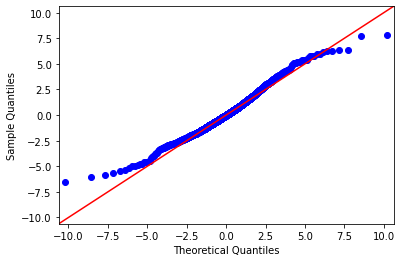

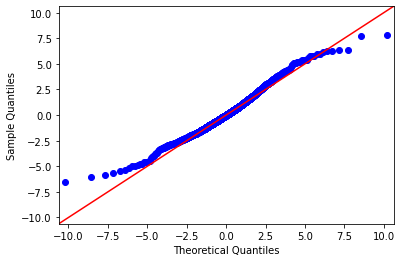

In [280]:
qqplot(error_analysis['residuals'] , stats.t, fit = True, line = '45')

In [177]:
error_analysis['std_residual'] = error_analysis['residuals']/((1/(len(error_analysis)-1))*(sum(error_analysis['residuals'])**2))**0.5

In [178]:
error_analysis['abs_std_residuals'] = abs(error_analysis['std_residual'])
mask = error_analysis['abs_std_residuals'] > 2
error_analysis[mask]

,year_month,town,trans_month,estimated_remaining_lease,flat_type,flat_model,storey_bins,floor_area_sqm,resale_trans,predictions,residuals,abs_res,std_residual,abs_std_residuals


In [179]:
error_analysis['predictions_untrans'] = error_analysis['predictions']**2
error_analysis['resale_price'] = y_test**2
error_analysis['actual_difference'] = error_analysis['resale_price'] - error_analysis['predictions_untrans']

In [194]:
len(error_analysis.loc[error_analysis['residuals']>1000])

2146